# Power plant optimization problem

# Requirements

In [1]:
import json
import gurobipy as gp
from gurobipy import GRB
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random

# First draft

## Data loading

In [2]:
random.seed(42)  # for reproducibility

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

# Max generation & storage
max_gen = {"Oil": 50.0*24, "Gas": 40.0*24, "Coal": 30.0*24}
storage_cap = {"Oil": max_gen["Oil"]*3, "Gas": max_gen["Gas"]*3, "Coal": max_gen["Coal"]*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# Weekly demand (inelastic)
demand_total = 12612  # MWh, similar scale as before

# ---------------------------
# Volatile price generation
# ---------------------------

def generate_price_path(base, daily_vol, spike_prob, spike_size_low, spike_size_high, num_days):
    """
    Generate a price path with:
      - base: average level
      - daily_vol: normal noise (std dev)
      - spike_prob: probability of a spike each day
      - spike_size_low/high: range for spike magnitude (additive)
    """
    prices = []
    level = base
    for d in range(num_days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_size_low, spike_size_high)
            level += spike

        # avoid negative prices
        level = max(5.0, level)

        prices.append(round(level, 1))
    return prices

fuel_bids = {}

# Rough typical cost levels (fuel + CO2 + VOM) in €/MWh:
# Coal cheaper, gas medium, oil most expensive.
tech_config = {
    "Coal": {
        "base_price": 65.0,
        "daily_vol": 3.0,
        "spike_prob": 0.15,
        "spike_size_low": 5.0,
        "spike_size_high": 20.0,
    },
    "Gas": {
        "base_price": 80.0,
        "daily_vol": 5.0,
        "spike_prob": 0.25,
        "spike_size_low": 10.0,
        "spike_size_high": 40.0,
    },
    "Oil": {
        "base_price": 100.0,
        "daily_vol": 4.0,
        "spike_prob": 0.20,
        "spike_size_low": 8.0,
        "spike_size_high": 30.0,
    },
}

fuel_bids = {}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]

    # Supplier 1: cheapest but limited quantity
    # Supplier 2: mid-price, more volume
    # Supplier 3: most expensive, plenty of volume (emergency/risk supplier)
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        # Small price premium between suppliers (but still follow the same volatility pattern)
        premium = (idx - 1) * 3.0  # e.g. +0, +3, +6 €/MWh

        base = cfg["base_price"] + premium

        prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_size_low=cfg["spike_size_low"],
            spike_size_high=cfg["spike_size_high"],
            num_days=num_days
        )

        # Max quantity per day: increase with supplier index
        # (cheapest has less, most expensive has most)
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            "price_EUR_per_MWh": prices,
            "max_MWh_per_day": max_qty
        }

# ---------------------------
# Demand bid (still inelastic)
# ---------------------------
demand_bid = {
    "type": "inelastic",
    "quantity_MWh": demand_total,
    "value_EUR_per_MWh": 1000.0
}

# ---------------------------
# Build full data structure
# ---------------------------
data = {
    "time": {
        "num_days": num_days
    },
    "demand": {
        "weekly_MWh": demand_total
    },
    "technologies": TECHS,
    "max_gen_MWh_per_day": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "demand_bid": demand_bid
}

# ---------------------------
# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_1.json", "w") as f:
    json.dump(data, f, indent=2)

print("Volatile data/data_draft_1.json generated.")


Volatile data/data_draft_1.json generated.


In [3]:
# -------------------------------------------------------
# Load data from JSON file
# -------------------------------------------------------
data_folder = Path("data")
data_file_path = data_folder / "data_draft_1.json"
data_file_path = data_file_path.resolve()
with open(data_file_path, "r") as f:
    data = json.load(f)

# Basic sets
TECHS = data["technologies"]
num_days = data["time"]["num_days"]
DAYS = range(num_days)

# Suppliers per technology
SUPPLIERS = {tech: data["suppliers"][tech] for tech in TECHS}

# Parameters
demand_total = data["demand"]["weekly_MWh"]

max_gen = data["max_gen_MWh_per_day"]  # dict tech -> float
storage_cap = data["storage_capacity_MWh"]
storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
init_inventory = data["initial_inventory_MWh"]

fuel_bids = data["fuel_bids"]  # nested dict: tech -> supplier -> {price[], max[]}
display(fuel_bids)

{'Oil': {'Oil_Supplier_1': {'price_EUR_per_MWh': [99.4,
    98.7,
    98.2,
    109.5,
    112.3,
    125.2,
    122.2],
   'max_MWh_per_day': [1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0]},
  'Oil_Supplier_2': {'price_EUR_per_MWh': [98.9,
    99.1,
    98.7,
    97.4,
    99.4,
    100.9,
    101.9],
   'max_MWh_per_day': [2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0]},
  'Oil_Supplier_3': {'price_EUR_per_MWh': [108.3,
    102.2,
    98.6,
    102.1,
    105.4,
    114.5,
    114.1],
   'max_MWh_per_day': [3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0]}},
 'Gas': {'Gas_Supplier_1': {'price_EUR_per_MWh': [100.3,
    97.2,
    111.6,
    118.3,
    147.3,
    149.9,
    154.0],
   'max_MWh_per_day': [1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0]},
  'Gas_Supplier_2': {'price_EUR_per_MWh': [75.9,
    73.2,
    73.4,
    74.7,
    77.6,
    89.2,
    86.4

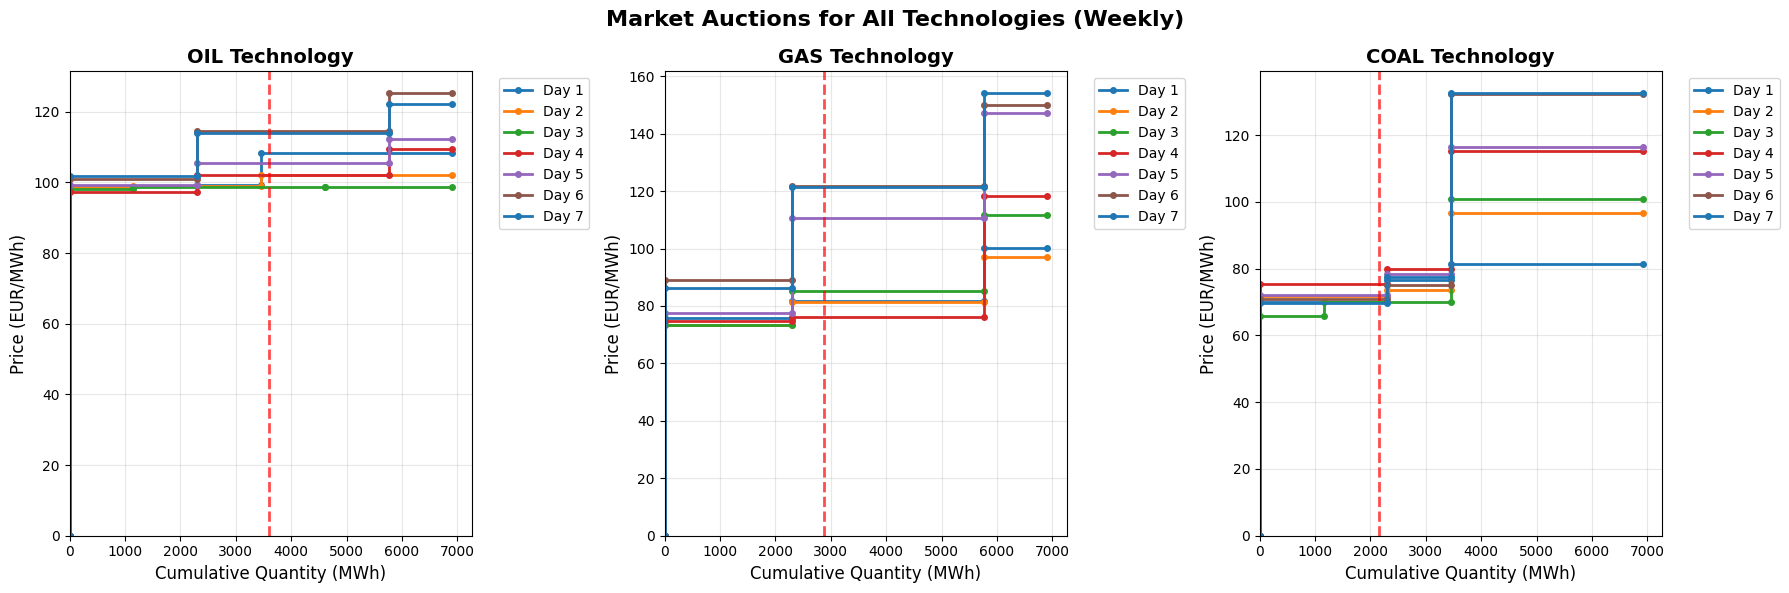


MARKET AUCTION SUMMARY

OIL Technology:
  Max Generation Capacity: 1200.0 MWh/day
  Number of Suppliers: 3
  Price Range: 97.40 - 125.20 EUR/MWh
  Average Price: 105.10 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day

GAS Technology:
  Max Generation Capacity: 960.0 MWh/day
  Number of Suppliers: 3
  Price Range: 73.20 - 154.00 EUR/MWh
  Average Price: 100.34 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day

COAL Technology:
  Max Generation Capacity: 720.0 MWh/day
  Number of Suppliers: 3
  Price Range: 65.70 - 132.50 EUR/MWh
  Average Price: 85.82 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day


In [4]:
# Create market auction plots for each technology
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Market Auctions for All Technologies (Weekly)', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for tech_idx, tech in enumerate(TECHS):
    ax = axes[tech_idx]
    
    # Plot supply curves for each day
    for day in DAYS:
        # Get all suppliers for this technology
        suppliers = SUPPLIERS[tech]
        
        # Collect price and quantity data for this day
        prices = []
        cumulative_quantities = []
        current_quantity = 0
        
        # Sort suppliers by price for proper merit order
        supplier_data = []
        for supplier in suppliers:
            price = fuel_bids[tech][supplier]["price_EUR_per_MWh"][day]
            max_quantity = fuel_bids[tech][supplier]["max_MWh_per_day"][day]
            supplier_data.append((price, max_quantity, supplier))
        
        # Sort by price (merit order)
        supplier_data.sort(key=lambda x: x[0])
        
        # Build supply curve
        prices.append(0)  # Start from 0
        cumulative_quantities.append(current_quantity)
        
        for price, max_quantity, supplier in supplier_data:
            # Add horizontal line at current quantity
            prices.append(price)
            cumulative_quantities.append(current_quantity)
            
            # Add vertical line to next quantity level
            current_quantity += max_quantity
            prices.append(price)
            cumulative_quantities.append(current_quantity)
        
        # Plot the supply curve for this day
        color = colors[day % len(colors)]
        ax.plot(cumulative_quantities, prices, 
               label=f'Day {day + 1}', 
               color=color, 
               linewidth=2,
               marker='o',
               markersize=4)
    
    # Formatting
    ax.set_title(f'{tech.upper()} Technology', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cumulative Quantity (MWh)', fontsize=12)
    ax.set_ylabel('Price (EUR/MWh)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add maximum generation limit line
    if tech in storage_cap:
        ax.axvline(x=storage_cap[tech], color='red', linestyle='--', 
                  linewidth=2, alpha=0.7, label=f'Max Gen: {max_gen[tech]} MWh')
    
    # Set reasonable axis limits
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print summary information
print("\n" + "="*80)
print("MARKET AUCTION SUMMARY")
print("="*80)

for tech in TECHS:
    print(f"\n{tech.upper()} Technology:")
    print(f"  Max Generation Capacity: {max_gen.get(tech, 'N/A')} MWh/day")
    print(f"  Number of Suppliers: {len(SUPPLIERS[tech])}")
    
    # Calculate average prices across all days and suppliers
    all_prices = []
    total_capacity = 0
    
    for day in DAYS:
        day_capacity = 0
        for supplier in SUPPLIERS[tech]:
            price = fuel_bids[tech][supplier]["price_EUR_per_MWh"][day]
            quantity = fuel_bids[tech][supplier]["max_MWh_per_day"][day]
            all_prices.append(price)
            day_capacity += quantity
        total_capacity = max(total_capacity, day_capacity)
    
    print(f"  Price Range: {min(all_prices):.2f} - {max(all_prices):.2f} EUR/MWh")
    print(f"  Average Price: {np.mean(all_prices):.2f} EUR/MWh")
    print(f"  Total Available Capacity: {total_capacity:.2f} MWh/day")

## Optimization program

In [5]:
# -------------------------------------------------------
# Model
# -------------------------------------------------------
m = gp.Model("Weekly_Fuel_Procurement_and_Storage_MultiSupplier")

# -------------------------------------------------------
# Decision variables
# -------------------------------------------------------

# purchase[tech, supplier, day]: energy purchased from supplier s for tech t on day d (MWh)
purchase = m.addVars(
    ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
    name="purchase",
    lb=0.0
)

# generate[tech, day]: energy generated by tech t on day d (MWh)
generate = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="generate",
    lb=0.0
)

# inventory[tech, day]: inventory of fuel for tech t at end of day d (MWh)
inventory = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="inventory",
    lb=0.0
)

# -------------------------------------------------------
# Objective: Minimize fuel purchase cost + storage cost
# -------------------------------------------------------

# Fuel purchase cost
purchase_cost = gp.quicksum(
    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d]
    for t in TECHS
    for s in SUPPLIERS[t]
    for d in DAYS
)

# Storage cost (rent per MWh stored per day)
storage_cost = gp.quicksum(
    storage_rent[t] * inventory[t, d]
    for t in TECHS
    for d in DAYS
)

m.setObjective(purchase_cost + storage_cost, GRB.MINIMIZE)

# -------------------------------------------------------
# Constraints
# -------------------------------------------------------

# 1) Inventory balance:
#    inventory[t,d] = inventory[t,d-1] + sum_s purchase[t,s,d] - generate[t,d]
#    -> ensures conservation of energy per technology over time
for t in TECHS:
    for d in DAYS:
        if d == 0:
            prev_inventory = init_inventory[t]
        else:
            prev_inventory = inventory[t, d - 1]

        m.addConstr(
            inventory[t, d] ==
            prev_inventory
            + gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t])
            - generate[t, d],
            name=f"inv_balance_{t}_day{d}"
        )

# 2) Generation capacity:
#    generate[t,d] <= max_gen[t]
#    -> respects physical max daily generation per technology
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            generate[t, d] <= max_gen[t],
            name=f"gen_cap_{t}_day{d}"
        )

# 3) Storage capacity:
#    inventory[t,d] <= storage_cap[t]
#    -> cannot store more fuel than the storage capacity
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            inventory[t, d] <= storage_cap[t],
            name=f"storage_cap_{t}_day{d}"
        )

# 4) Supplier offer limits:
#    purchase[t,s,d] <= max_offer[t,s,d]
#    -> you cannot buy more from a supplier than their auction offer
for t in TECHS:
    for s in SUPPLIERS[t]:
        for d in DAYS:
            max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
            m.addConstr(
                purchase[t, s, d] <= max_offer,
                name=f"supplier_cap_{t}_{s}_day{d}"
            )

# 5) Weekly demand satisfaction:
#    sum_t sum_d generate[t,d] = demand_total
#    -> inelastic demand: must be fully met over the week
m.addConstr(
    gp.quicksum(generate[t, d] for t in TECHS for d in DAYS) == demand_total,
    name="weekly_demand"
)

# 6) End-of-week inventory = 0:
#    inventory[t, last_day] = 0
#    -> avoids leaving unused fuel at the end (no terminal value assumed)
last_day = num_days - 1
for t in TECHS:
    m.addConstr(
        inventory[t, last_day] == 0.0,
        name=f"end_inventory_zero_{t}"
    )

# (Non-negativity is already enforced via lb=0.0 on variables)


# -------------------------------------------------------
# Solve
# -------------------------------------------------------
m.optimize()

# -------------------------------------------------------
# Print solution
# -------------------------------------------------------
if m.status == GRB.OPTIMAL:
    print(f"Optimal objective value (total cost): {m.objVal:.2f} EUR")

    print("\n=== Purchases (MWh) by tech / supplier / day ===")
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                val = purchase[t, s, d].X
                if val > 1e-6:
                    print(f"Purchase[{t}, {s}, day {d}] = {val:.2f} MWh")

    print("\n=== Generation (MWh) by tech / day ===")
    for t in TECHS:
        for d in DAYS:
            val = generate[t, d].X
            if val > 1e-6:
                print(f"Generate[{t}, day {d}] = {val:.2f} MWh")

    print("\n=== Inventory (MWh) by tech / day ===")
    for t in TECHS:
        for d in DAYS:
            val = inventory[t, d].X
            if val > 1e-6:
                print(f"Inventory[{t}, day {d}] = {val:.2f} MWh")
else:
    print(f"Model ended with status {m.status}")

Set parameter Username
Set parameter LicenseID to value 2663265
Academic license - for non-commercial use only - expires 2026-05-10
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 130 rows, 105 columns and 252 nonzeros
Model fingerprint: 0xab6f092d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 1e+04]
Presolve removed 108 rows and 24 columns
Presolve time: 0.01s
Presolved: 22 rows, 81 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.003000e+03   0.000000e+00      0s
      18    9.3964080e+05   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.04 seconds (0.00 work units)
Opti

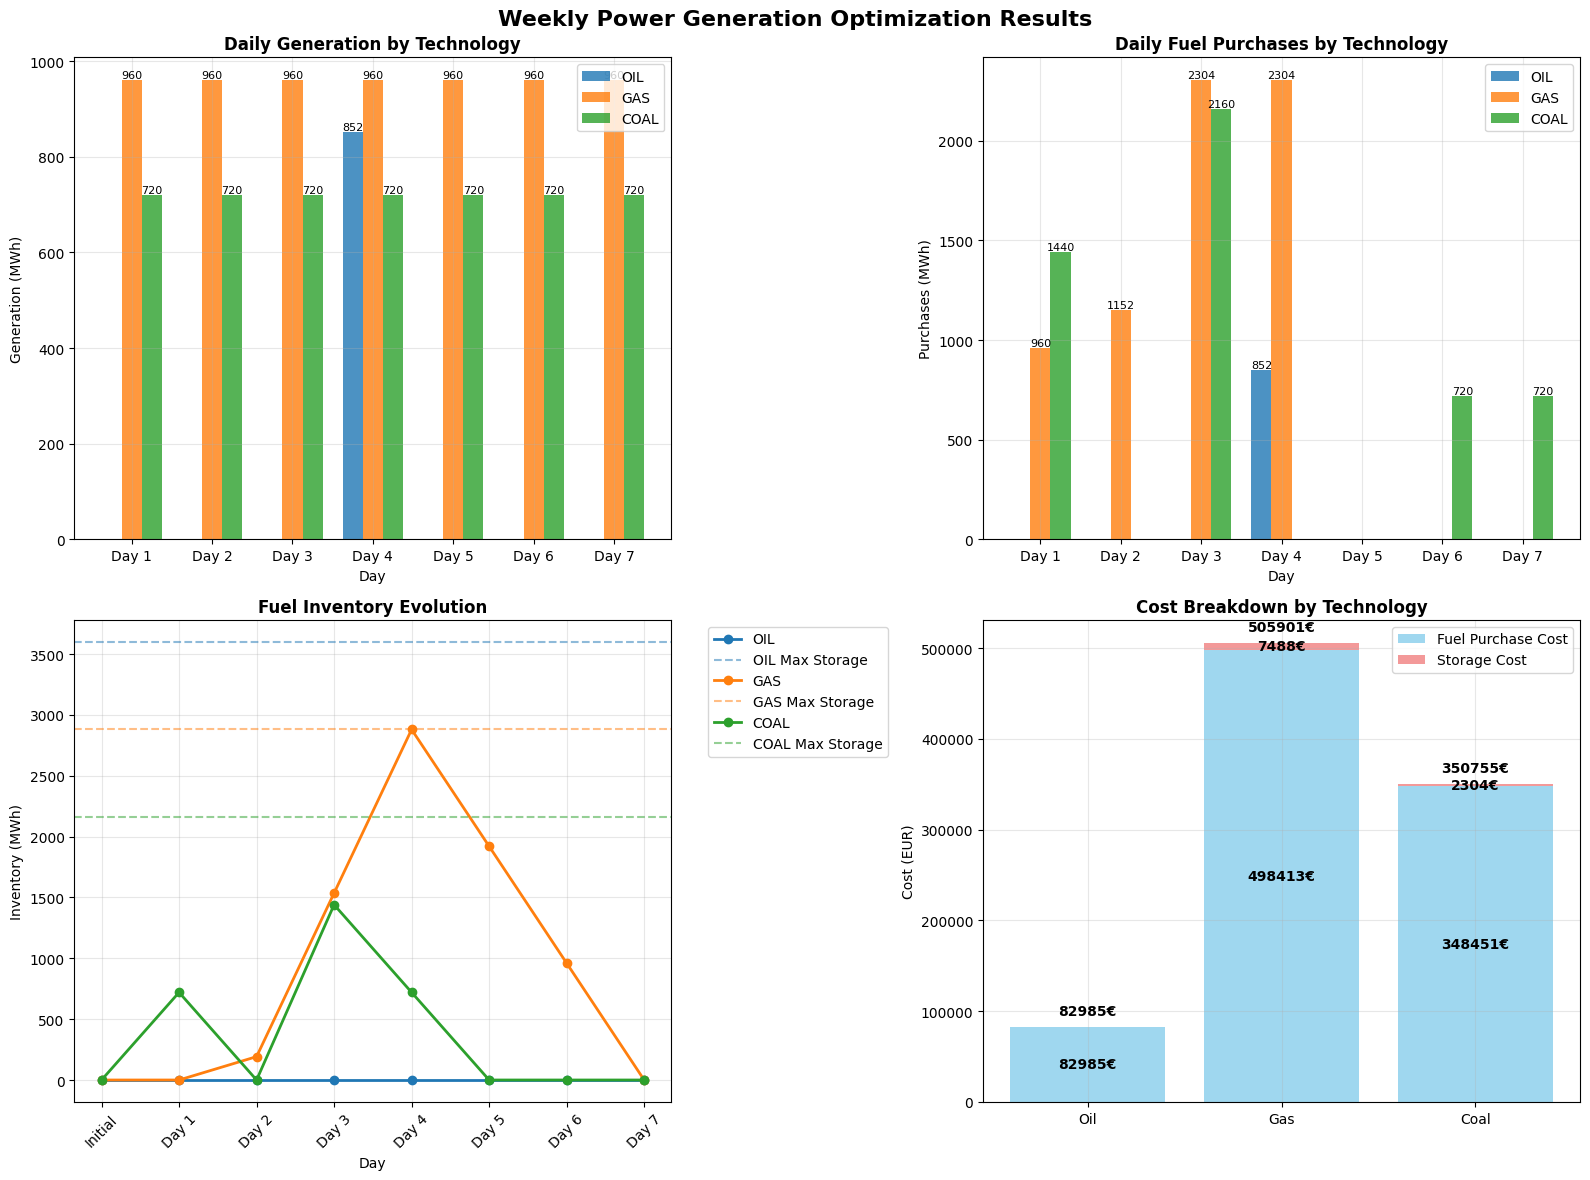


OPTIMIZATION RESULTS SUMMARY

Total Weekly Generation: 12612.00 MWh
Total Weekly Demand: 12612.00 MWh
Total Weekly Purchases: 12612.00 MWh
Total Cost: 939640.80 EUR

Cost Breakdown:
  Fuel Purchase Cost: 929848.80 EUR (99.0%)
  Storage Cost: 9792.00 EUR (1.0%)

Generation by Technology:
  OIL: 852.00 MWh (6.8% of total, 10.1% capacity utilization)
  GAS: 6720.00 MWh (53.3% of total, 100.0% capacity utilization)
  COAL: 5040.00 MWh (40.0% of total, 100.0% capacity utilization)

Storage Utilization:
  OIL: Max 0.00 MWh (0.0% of capacity), Avg 0.00 MWh
  GAS: Max 2880.00 MWh (100.0% of capacity), Avg 1069.71 MWh
  COAL: Max 1440.00 MWh (66.7% of capacity), Avg 411.43 MWh


In [6]:
# -------------------------------------------------------
# Visualization of optimization results
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Extract solution data
    purchase_data = {}
    generate_data = {}
    inventory_data = {}
    
    for t in TECHS:
        purchase_data[t] = []
        generate_data[t] = []
        inventory_data[t] = []
        
        for d in DAYS:
            # Sum purchases across all suppliers for each tech/day
            total_purchase = sum(purchase[t, s, d].X for s in SUPPLIERS[t])
            purchase_data[t].append(total_purchase)
            generate_data[t].append(generate[t, d].X)
            inventory_data[t].append(inventory[t, d].X)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Weekly Power Generation Optimization Results', fontsize=16, fontweight='bold')
    
    days_labels = [f'Day {d+1}' for d in DAYS]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # 1. Daily Generation by Technology
    ax1 = axes[0, 0]
    width = 0.25
    x = np.arange(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        bars = ax1.bar(x + i*width, generate_data[tech], width, 
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    ax1.set_title('Daily Generation by Technology', fontweight='bold')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Generation (MWh)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(days_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Daily Fuel Purchases by Technology
    ax2 = axes[0, 1]
    for i, tech in enumerate(TECHS):
        bars = ax2.bar(x + i*width, purchase_data[tech], width,
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    ax2.set_title('Daily Fuel Purchases by Technology', fontweight='bold')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Purchases (MWh)')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(days_labels)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Inventory Evolution
    ax3 = axes[1, 0]
    for i, tech in enumerate(TECHS):
        # Add initial inventory as day 0
        inv_with_initial = [init_inventory[tech]] + inventory_data[tech]
        days_with_initial = ['Initial'] + days_labels
        
        ax3.plot(days_with_initial, inv_with_initial, 
                marker='o', linewidth=2, markersize=6,
                label=tech.upper(), color=colors[i])
        
        # Add storage capacity limit
        ax3.axhline(y=storage_cap[tech], color=colors[i], 
                   linestyle='--', alpha=0.5, 
                   label=f'{tech.upper()} Max Storage')
    
    ax3.set_title('Fuel Inventory Evolution', fontweight='bold')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Inventory (MWh)')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Cost Breakdown
    ax4 = axes[1, 1]
    
    # Calculate costs by technology and component
    tech_purchase_costs = {}
    tech_storage_costs = {}
    
    for t in TECHS:
        # Purchase costs
        purchase_cost_tech = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for s in SUPPLIERS[t]
            for d in DAYS
        )
        tech_purchase_costs[t] = purchase_cost_tech
        
        # Storage costs
        storage_cost_tech = sum(
            storage_rent[t] * inventory[t, d].X
            for d in DAYS
        )
        tech_storage_costs[t] = storage_cost_tech
    
    # Create stacked bar chart
    purchase_costs = [tech_purchase_costs[t] for t in TECHS]
    storage_costs = [tech_storage_costs[t] for t in TECHS]
    
    bars1 = ax4.bar(TECHS, purchase_costs, label='Fuel Purchase Cost', 
                    color='skyblue', alpha=0.8)
    bars2 = ax4.bar(TECHS, storage_costs, bottom=purchase_costs, 
                    label='Storage Cost', color='lightcoral', alpha=0.8)
    
    # Add value labels
    for i, (tech, purchase, storage) in enumerate(zip(TECHS, purchase_costs, storage_costs)):
        total = purchase + storage
        if purchase > 0:
            ax4.text(i, purchase/2, f'{purchase:.0f}€', 
                    ha='center', va='center', fontweight='bold')
        if storage > 0:
            ax4.text(i, purchase + storage/2, f'{storage:.0f}€', 
                    ha='center', va='center', fontweight='bold')
        ax4.text(i, total + max(purchase_costs + storage_costs)*0.02, 
                f'{total:.0f}€', ha='center', va='bottom', fontweight='bold')
    
    ax4.set_title('Cost Breakdown by Technology', fontweight='bold')
    ax4.set_ylabel('Cost (EUR)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("OPTIMIZATION RESULTS SUMMARY")
    print("="*80)
    
    total_generation = sum(sum(generate_data[t]) for t in TECHS)
    total_purchase = sum(sum(purchase_data[t]) for t in TECHS)
    
    print(f"\nTotal Weekly Generation: {total_generation:.2f} MWh")
    print(f"Total Weekly Demand: {demand_total:.2f} MWh")
    print(f"Total Weekly Purchases: {total_purchase:.2f} MWh")
    print(f"Total Cost: {m.objVal:.2f} EUR")
    
    print(f"\nCost Breakdown:")
    total_fuel_cost = sum(tech_purchase_costs.values())
    total_storage_cost = sum(tech_storage_costs.values())
    print(f"  Fuel Purchase Cost: {total_fuel_cost:.2f} EUR ({100*total_fuel_cost/m.objVal:.1f}%)")
    print(f"  Storage Cost: {total_storage_cost:.2f} EUR ({100*total_storage_cost/m.objVal:.1f}%)")
    
    print(f"\nGeneration by Technology:")
    for t in TECHS:
        tech_total = sum(generate_data[t])
        utilization = tech_total / (max_gen[t] * len(DAYS)) * 100
        print(f"  {t.upper()}: {tech_total:.2f} MWh ({100*tech_total/total_generation:.1f}% of total, {utilization:.1f}% capacity utilization)")
    
    print(f"\nStorage Utilization:")
    for t in TECHS:
        max_inventory = max(inventory_data[t])
        avg_inventory = np.mean(inventory_data[t])
        print(f"  {t.upper()}: Max {max_inventory:.2f} MWh ({100*max_inventory/storage_cap[t]:.1f}% of capacity), Avg {avg_inventory:.2f} MWh")

else:
    print("No optimal solution found - cannot create plots")

# Second draft

## Data loading

In [7]:
import json
import random

random.seed(42)  # reproducible

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
num_hours = 24

TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

# Hourly factors shape; peak around midday / evening.
hourly_factors = [
    0.55, 0.50, 0.48, 0.47, 0.48, 0.55,  # 0-5: low night
    0.65, 0.75, 0.80, 0.85, 0.90, 0.95,  # 6-11: ramp up
    1.00, 0.95, 0.90, 0.92, 1.00, 0.98,  # 12-17: high / evening peak
    0.90, 0.85, 0.80, 0.75, 0.70, 0.60   # 18-23: decline
]
assert len(hourly_factors) == num_hours
avg_hour_factors = sum(hourly_factors) / num_hours

# Max generation & storage (interpret as *hourly* max power)
max_gen = {"Oil": 50.0, "Gas": 40.0, "Coal": 30.0}

# Weekly demand target (approx)
weekly_demand_target = sum(max_gen[i] for i in max_gen) * avg_hour_factors * num_hours * num_days # MWh

storage_cap = {"Oil": max_gen["Oil"]*24*3, "Gas": max_gen["Gas"]*24*3, "Coal": max_gen["Coal"]*24*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# =====================================================
# Helper: volatile path generator (for prices)
# =====================================================
def generate_price_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Generate a volatile path with Gaussian noise and occasional *upward* spikes.
    Used for fuel and electricity prices.
    """
    prices = []
    level = base
    for d in range(days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional upward spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_low, spike_high)
            level += spike

        # avoid negative or too low prices
        level = max(5.0, level)
        prices.append(round(level, 1))
    return prices


# =====================================================
# 1) Fuel bids with volatility & spikes (daily auctions)
# =====================================================
fuel_bids = {}

tech_config = {
    "Coal": {
        "base_price": 65.0,  # €/MWh, cheapest
        "daily_vol": 3.0,
        "spike_prob": 0.15,
        "spike_low": 5.0,
        "spike_high": 20.0,
    },
    "Gas": {
        "base_price": 80.0,  # €/MWh, mid
        "daily_vol": 5.0,
        "spike_prob": 0.25,
        "spike_low": 10.0,
        "spike_high": 40.0,
    },
    "Oil": {
        "base_price": 100.0,  # €/MWh, most expensive
        "daily_vol": 4.0,
        "spike_prob": 0.20,
        "spike_low": 8.0,
        "spike_high": 30.0,
    },
}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        premium = (idx - 1) * 3.0  # each supplier slightly more expensive
        base = cfg["base_price"] + premium

        prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_low=cfg["spike_low"],
            spike_high=cfg["spike_high"],
            days=num_days
        )

        # cheap supplier has less volume, expensive has more
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*num_hours*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            "price_EUR_per_MWh": prices,
            "max_MWh_per_day": max_qty
        }


# =====================================================
# 2) Daily electricity price path (Danish-like level)
# =====================================================
elec_base_price = 85.0  # €/MWh reference level
daily_elec_price = generate_price_path(
    base=elec_base_price,
    daily_vol=6.0,
    spike_prob=0.20,
    spike_low=10.0,
    spike_high=40.0,
    days=num_days
)


# =====================================================
# 3) Daily demand path with *downward* volatility
# =====================================================
def generate_downward_demand_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Volatile daily demand path mainly moving downward (e.g. due to RES, efficiency).
    - Negative bias in daily shocks
    - Occasional downward spikes
    - Then scaled so that weekly sum matches weekly_demand_target
    """
    demands = []
    level = base
    for d in range(days):
        # negative-biased shock
        shock = -abs(random.gauss(0, daily_vol))
        level += shock

        # occasional downward spike
        if random.random() < spike_prob:
            spike = -random.uniform(spike_low, spike_high)
            level += spike

        # avoid zero or negative demand
        level = max(0.1 * base, level)
        demands.append(level)

    # scale to match weekly target
    current_sum = sum(demands)
    scale = weekly_demand_target / current_sum
    demands = [round(d * scale, 3) for d in demands]
    return demands


base_daily = weekly_demand_target / num_days
daily_demand = generate_downward_demand_path(
    base=base_daily,
    daily_vol=1.0,
    spike_prob=0.20,
    spike_low=1.0,
    spike_high=3.0,
    days=num_days
)


# =====================================================
# Hourly demand factors and hourly demand (MWh)
# =====================================================


# Normalize so max factor = 1.0 (as per your “factor = 1” definition)
max_factor = max(hourly_factors)
hourly_factors = [round(x / max_factor, 3) for x in hourly_factors]
factor_sum = sum(hourly_factors)

# Compute hourly demand so that sum_h demand[d,h] = daily_demand[d]
hourly_demand = []
for d in range(num_days):
    day_row = []
    for h in range(num_hours):
        val = daily_demand[d] * (hourly_factors[h] / factor_sum)
        day_row.append(round(val, 4))
    hourly_demand.append(day_row)


# =====================================================
# 5) Hourly electricity prices (from daily path + shape)
# =====================================================
# Use the *same* shape as demand to create intraday price pattern,
# but normalize to keep average = 1 so daily average price ≈ daily_elec_price[d].

mean_factor = factor_sum / num_hours
hourly_price_factor = [f / mean_factor for f in hourly_factors]

hourly_elec_price = []
for d in range(num_days):
    row = []
    for h in range(num_hours):
        price = daily_elec_price[d] * hourly_price_factor[h]
        row.append(round(price, 2))
    hourly_elec_price.append(row)


# =====================================================
# 6) Revenue factors per technology (emission penalty)
# =====================================================
# Coal most penalized, gas least.
revenue_factor = {
    "Coal": 0.80,
    "Oil": 0.90,
    "Gas": 0.95
}


# =====================================================
# 7) Demand bid meta-info
# =====================================================
demand_bid = {
    "type": "inelastic_hourly_based_on_daily",
    "weekly_target_MWh": weekly_demand_target,
    "daily_MWh": daily_demand
}

load_deviation_penalty = {
    "under_generation": 250.0,  # EUR/MWh shortage penalty
    "over_generation": 150.0,   # EUR/MWh excess penalty  
    "description": "Grid balancing and stability penalties",
    "basis": "European TSO imbalance settlement mechanisms"
}

# =====================================================
# Build and save the full data structure
# =====================================================
data = {
    "time": {
        "num_days": num_days,
        "num_hours": num_hours
    },
    "demand": {
        "daily_MWh": daily_demand,
        "hourly_factor": hourly_factors,
        "hourly_MWh": hourly_demand  # shape [day][hour]
    },
    "technologies": TECHS,
    "max_gen_MWh_per_hour": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "electricity_price_EUR_per_MWh_daily": daily_elec_price,
    "electricity_price_EUR_per_MWh_hourly": hourly_elec_price,  # shape [day][hour]
    "revenue_factor": revenue_factor,
    "demand_bid": demand_bid,
    "load_deviation_penalty": load_deviation_penalty
}

# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_2.json", "w") as f:
    json.dump(data, f, indent=2)

print("New data/data_draft_2.json with HOURLY demand and HOURLY electricity prices generated.")


New data/data_draft_2.json with HOURLY demand and HOURLY electricity prices generated.


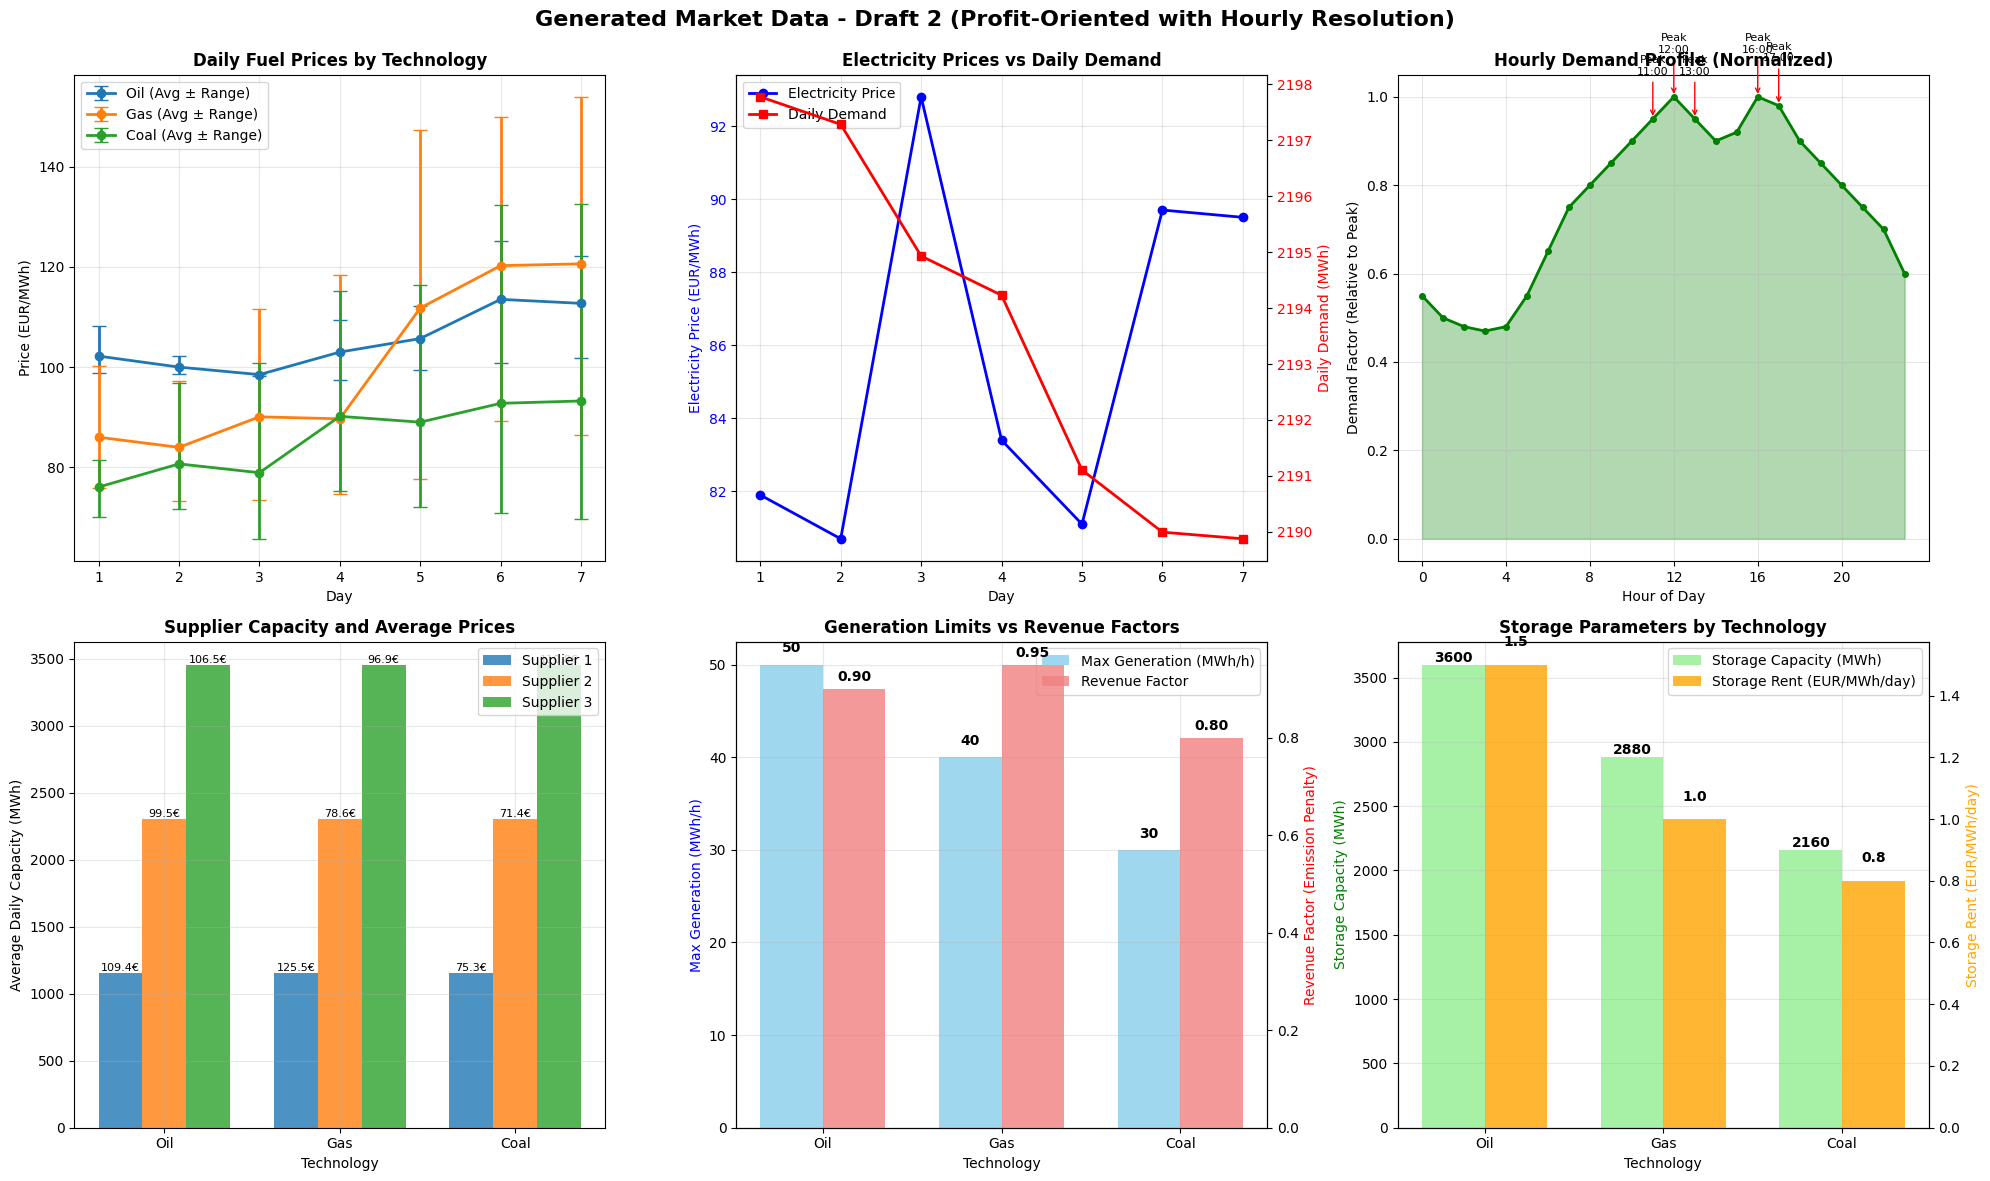

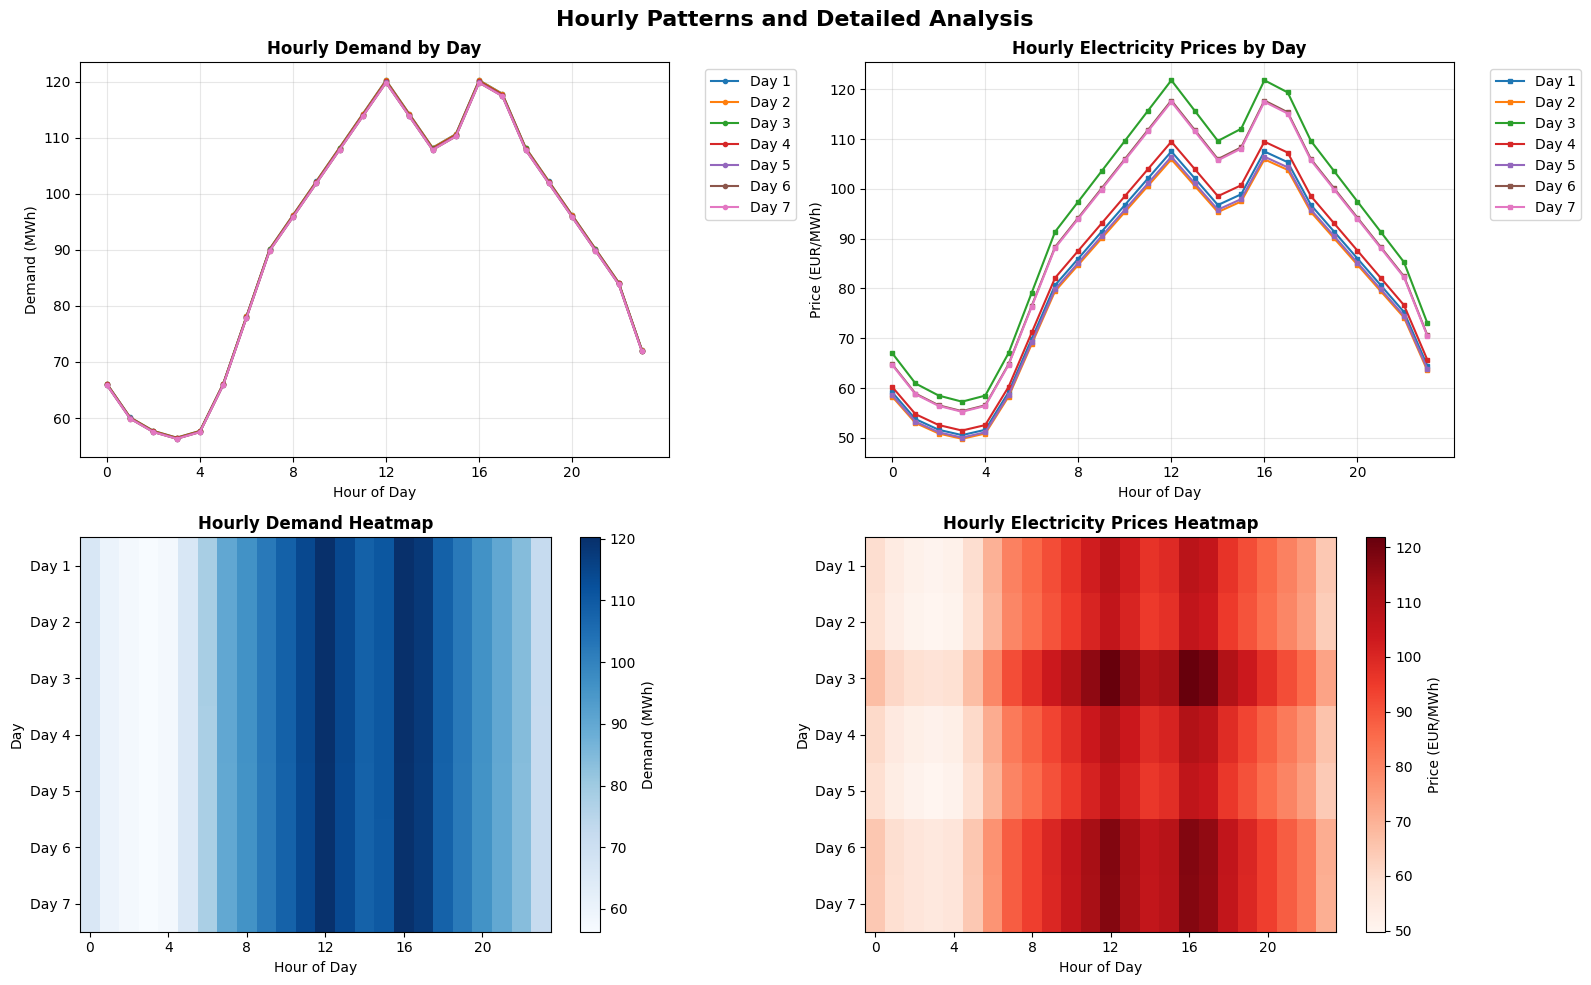


GENERATED DATA SUMMARY - DRAFT 2

Time Structure:
  Days: 7
  Hours per day: 24
  Total time periods: 168

Demand Structure:
  Weekly target: 15355.2 MWh
  Daily demand range: 2189.9 - 2197.8 MWh
  Total weekly demand: 15355.2 MWh
  Hourly factor range: 0.470 - 1.000

Electricity Prices:
  Base price: 85.0 EUR/MWh
  Daily price range: 80.7 - 92.8 EUR/MWh
  Daily average price: 85.6 EUR/MWh
  Hourly price range: 49.8 - 121.8 EUR/MWh

Technology Overview:
  OIL:
    Max generation: 50 MWh/h
    Storage capacity: 3600 MWh
    Storage rent: 1.5 EUR/MWh/day
    Revenue factor: 0.90
    Average fuel price: 105.1 EUR/MWh
    Average daily supplier capacity: 6912.0 MWh
  GAS:
    Max generation: 40 MWh/h
    Storage capacity: 2880 MWh
    Storage rent: 1.0 EUR/MWh/day
    Revenue factor: 0.95
    Average fuel price: 100.3 EUR/MWh
    Average daily supplier capacity: 6912.0 MWh
  COAL:
    Max generation: 30 MWh/h
    Storage capacity: 2160 MWh
    Storage rent: 0.8 EUR/MWh/day
    Revenue fac

In [8]:
# -------------------------------------------------------
# Visualization of Generated Data (Draft 2)
# -------------------------------------------------------

# Create comprehensive data visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Generated Market Data - Draft 2 (Profit-Oriented with Hourly Resolution)', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
days_range = range(1, num_days + 1)

# 1. Fuel Prices by Technology over Time
ax1 = axes[0, 0]
for tech_idx, tech in enumerate(TECHS):
    # Plot average price across all suppliers for each day
    daily_avg_prices = []
    daily_min_prices = []
    daily_max_prices = []
    
    for day in range(num_days):
        day_prices = [fuel_bids[tech][supplier]["price_EUR_per_MWh"][day] 
                     for supplier in SUPPLIERS[tech]]
        daily_avg_prices.append(np.mean(day_prices))
        daily_min_prices.append(min(day_prices))
        daily_max_prices.append(max(day_prices))
    
    # Plot average with error bars showing min/max range
    ax1.errorbar(days_range, daily_avg_prices, 
                yerr=[np.array(daily_avg_prices) - np.array(daily_min_prices),
                      np.array(daily_max_prices) - np.array(daily_avg_prices)],
                label=f'{tech} (Avg ± Range)', color=colors[tech_idx], 
                marker='o', linewidth=2, capsize=5)

ax1.set_title('Daily Fuel Prices by Technology', fontweight='bold')
ax1.set_xlabel('Day')
ax1.set_ylabel('Price (EUR/MWh)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Electricity Prices vs Daily Demand
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

# Plot electricity prices
line1 = ax2.plot(days_range, daily_elec_price, 'b-o', linewidth=2, markersize=6, 
                label='Electricity Price')
ax2.set_ylabel('Electricity Price (EUR/MWh)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Plot daily demand on secondary axis
line2 = ax2_twin.plot(days_range, daily_demand, 'r-s', linewidth=2, markersize=6,
                     label='Daily Demand')
ax2_twin.set_ylabel('Daily Demand (MWh)', color='r')
ax2_twin.tick_params(axis='y', labelcolor='r')

ax2.set_title('Electricity Prices vs Daily Demand', fontweight='bold')
ax2.set_xlabel('Day')
ax2.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left')

# 3. Hourly Demand Profile (24h shape)
ax3 = axes[0, 2]
hours_range = range(24)
ax3.plot(hours_range, hourly_factors, 'g-o', linewidth=2, markersize=4)
ax3.fill_between(hours_range, hourly_factors, alpha=0.3, color='green')

ax3.set_title('Hourly Demand Profile (Normalized)', fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Demand Factor (Relative to Peak)')
ax3.set_xticks(range(0, 24, 4))
ax3.grid(True, alpha=0.3)

# Add peak hour annotations
peak_hours = [i for i, f in enumerate(hourly_factors) if f >= 0.95]
for peak_hour in peak_hours:
    ax3.annotate(f'Peak\n{peak_hour}:00', 
                xy=(peak_hour, hourly_factors[peak_hour]), 
                xytext=(peak_hour, hourly_factors[peak_hour] + 0.1),
                ha='center', fontsize=8,
                arrowprops=dict(arrowstyle='->', color='red', lw=1))

# 4. Supplier Capacity and Price Structure
ax4 = axes[1, 0]
width = 0.25
x_pos = np.arange(len(TECHS))

for supplier_idx in range(3):  # 3 suppliers per technology
    capacities = []
    avg_prices = []
    
    for tech in TECHS:
        supplier_name = SUPPLIERS[tech][supplier_idx]
        # Average capacity across all days
        avg_capacity = np.mean(fuel_bids[tech][supplier_name]["max_MWh_per_day"])
        # Average price across all days
        avg_price = np.mean(fuel_bids[tech][supplier_name]["price_EUR_per_MWh"])
        
        capacities.append(avg_capacity)
        avg_prices.append(avg_price)
    
    bars = ax4.bar(x_pos + supplier_idx * width, capacities, width,
                  label=f'Supplier {supplier_idx + 1}', alpha=0.8)
    
    # Add price labels on bars
    for i, (bar, price) in enumerate(zip(bars, avg_prices)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{price:.1f}€', ha='center', va='bottom', fontsize=8)

ax4.set_title('Supplier Capacity and Average Prices', fontweight='bold')
ax4.set_xlabel('Technology')
ax4.set_ylabel('Average Daily Capacity (MWh)')
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels(TECHS)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Revenue Factors and Generation Limits
ax5 = axes[1, 1]
x_tech = np.arange(len(TECHS))
width = 0.35

# Plot max generation capacity
bars1 = ax5.bar(x_tech - width/2, [max_gen[tech] for tech in TECHS], 
               width, label='Max Generation (MWh/h)', alpha=0.8, color='skyblue')

# Plot revenue factors on secondary axis
ax5_twin = ax5.twinx()
bars2 = ax5_twin.bar(x_tech + width/2, [revenue_factor[tech] for tech in TECHS], 
                    width, label='Revenue Factor', alpha=0.8, color='lightcoral')

ax5.set_xlabel('Technology')
ax5.set_ylabel('Max Generation (MWh/h)', color='blue')
ax5_twin.set_ylabel('Revenue Factor (Emission Penalty)', color='red')
ax5.set_title('Generation Limits vs Revenue Factors', fontweight='bold')
ax5.set_xticks(x_tech)
ax5.set_xticklabels(TECHS)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Max generation labels
    height1 = bar1.get_height()
    ax5.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
            f'{height1:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Revenue factor labels
    height2 = bar2.get_height()
    ax5_twin.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                 f'{height2:.2f}', ha='center', va='bottom', fontweight='bold')

ax5.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 6. Storage and Cost Parameters
ax6 = axes[1, 2]
x_tech = np.arange(len(TECHS))
width = 0.35

# Plot storage capacity
bars1 = ax6.bar(x_tech - width/2, [storage_cap[tech] for tech in TECHS], 
               width, label='Storage Capacity (MWh)', alpha=0.8, color='lightgreen')

# Plot storage rent on secondary axis
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar(x_tech + width/2, [storage_rent[tech] for tech in TECHS], 
                    width, label='Storage Rent (EUR/MWh/day)', alpha=0.8, color='orange')

ax6.set_xlabel('Technology')
ax6.set_ylabel('Storage Capacity (MWh)', color='green')
ax6_twin.set_ylabel('Storage Rent (EUR/MWh/day)', color='orange')
ax6.set_title('Storage Parameters by Technology', fontweight='bold')
ax6.set_xticks(x_tech)
ax6.set_xticklabels(TECHS)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Storage capacity labels
    height1 = bar1.get_height()
    ax6.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
            f'{height1:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Storage rent labels
    height2 = bar2.get_height()
    ax6_twin.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.05,
                 f'{height2:.1f}', ha='center', va='bottom', fontweight='bold')

ax6.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Additional Hourly Patterns Visualization
# -------------------------------------------------------

# Create separate figure for hourly patterns
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))
fig2.suptitle('Hourly Patterns and Detailed Analysis', fontsize=16, fontweight='bold')

# 1. Hourly Demand for Each Day
ax2_1 = axes2[0, 0]
for d in range(num_days):
    ax2_1.plot(range(24), hourly_demand[d], label=f'Day {d+1}', 
              marker='o', linewidth=1.5, markersize=3)

ax2_1.set_title('Hourly Demand by Day', fontweight='bold')
ax2_1.set_xlabel('Hour of Day')
ax2_1.set_ylabel('Demand (MWh)')
ax2_1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2_1.grid(True, alpha=0.3)
ax2_1.set_xticks(range(0, 24, 4))

# 2. Hourly Electricity Prices for Each Day
ax2_2 = axes2[0, 1]
for d in range(num_days):
    ax2_2.plot(range(24), hourly_elec_price[d], label=f'Day {d+1}', 
              marker='s', linewidth=1.5, markersize=3)

ax2_2.set_title('Hourly Electricity Prices by Day', fontweight='bold')
ax2_2.set_xlabel('Hour of Day')
ax2_2.set_ylabel('Price (EUR/MWh)')
ax2_2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2_2.grid(True, alpha=0.3)
ax2_2.set_xticks(range(0, 24, 4))

# 3. Heatmap of Hourly Demand
ax2_3 = axes2[1, 0]
demand_matrix = np.array(hourly_demand)
im1 = ax2_3.imshow(demand_matrix, cmap='Blues', aspect='auto')
ax2_3.set_title('Hourly Demand Heatmap', fontweight='bold')
ax2_3.set_xlabel('Hour of Day')
ax2_3.set_ylabel('Day')
ax2_3.set_xticks(range(0, 24, 4))
ax2_3.set_yticks(range(num_days))
ax2_3.set_yticklabels([f'Day {d+1}' for d in range(num_days)])
plt.colorbar(im1, ax=ax2_3, label='Demand (MWh)')

# 4. Heatmap of Hourly Electricity Prices
ax2_4 = axes2[1, 1]
price_matrix = np.array(hourly_elec_price)
im2 = ax2_4.imshow(price_matrix, cmap='Reds', aspect='auto')
ax2_4.set_title('Hourly Electricity Prices Heatmap', fontweight='bold')
ax2_4.set_xlabel('Hour of Day')
ax2_4.set_ylabel('Day')
ax2_4.set_xticks(range(0, 24, 4))
ax2_4.set_yticks(range(num_days))
ax2_4.set_yticklabels([f'Day {d+1}' for d in range(num_days)])
plt.colorbar(im2, ax=ax2_4, label='Price (EUR/MWh)')

plt.tight_layout()
plt.show()

# Print data summary
print("\n" + "="*80)
print("GENERATED DATA SUMMARY - DRAFT 2")
print("="*80)

print(f"\nTime Structure:")
print(f"  Days: {num_days}")
print(f"  Hours per day: {num_hours}")
print(f"  Total time periods: {num_days * num_hours}")

print(f"\nDemand Structure:")
print(f"  Weekly target: {weekly_demand_target:.1f} MWh")
print(f"  Daily demand range: {min(daily_demand):.1f} - {max(daily_demand):.1f} MWh")
print(f"  Total weekly demand: {sum(daily_demand):.1f} MWh")
print(f"  Hourly factor range: {min(hourly_factors):.3f} - {max(hourly_factors):.3f}")

print(f"\nElectricity Prices:")
print(f"  Base price: {elec_base_price:.1f} EUR/MWh")
print(f"  Daily price range: {min(daily_elec_price):.1f} - {max(daily_elec_price):.1f} EUR/MWh")
print(f"  Daily average price: {np.mean(daily_elec_price):.1f} EUR/MWh")
print(f"  Hourly price range: {min(min(row) for row in hourly_elec_price):.1f} - {max(max(row) for row in hourly_elec_price):.1f} EUR/MWh")

print(f"\nTechnology Overview:")
for tech in TECHS:
    # Calculate average fuel price across all suppliers and days
    all_prices = []
    total_capacity = 0
    for supplier in SUPPLIERS[tech]:
        all_prices.extend(fuel_bids[tech][supplier]["price_EUR_per_MWh"])
        total_capacity += sum(fuel_bids[tech][supplier]["max_MWh_per_day"])
    
    avg_fuel_price = np.mean(all_prices)
    avg_capacity = total_capacity / num_days
    
    print(f"  {tech.upper()}:")
    print(f"    Max generation: {max_gen[tech]:.0f} MWh/h")
    print(f"    Storage capacity: {storage_cap[tech]:.0f} MWh")
    print(f"    Storage rent: {storage_rent[tech]:.1f} EUR/MWh/day")
    print(f"    Revenue factor: {revenue_factor[tech]:.2f}")
    print(f"    Average fuel price: {avg_fuel_price:.1f} EUR/MWh")
    print(f"    Average daily supplier capacity: {avg_capacity:.1f} MWh")

print(f"\nMarket Characteristics:")
print(f"  Number of suppliers per technology: {len(SUPPLIERS[TECHS[0]])}")
print(f"  Price volatility: Fuel prices include spikes and daily variations")
print(f"  Demand pattern: Daily variations with hourly load shape")
print(f"  Emission penalties: Reflected in revenue factors (Coal < Oil < Gas)")

## Optimization program

In [9]:

# -------------------------------------------------------
# Load data from JSON file
# -------------------------------------------------------
data_folder = Path("data")
data_file_path = data_folder / "data_draft_2.json"
data_file_path = data_file_path.resolve()
with open(data_file_path, "r") as f:
    data = json.load(f)

TECHS = data["technologies"]
num_days = data["time"]["num_days"]
num_hours = data["time"]["num_hours"]
DAYS = range(num_days)
HOURS = range(num_hours)

SUPPLIERS = {t: data["suppliers"][t] for t in TECHS}

# Demand
daily_demand = data["demand"]["daily_MWh"]            # [day]
hourly_demand = data["demand"]["hourly_MWh"]          # [day][hour]

# Tech parameters
max_gen = data["max_gen_MWh_per_hour"]                # tech -> hourly max
storage_cap = data["storage_capacity_MWh"]
storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
init_inventory = data["initial_inventory_MWh"]

# Market data
fuel_bids = data["fuel_bids"]                         # tech -> supplier -> {price[], max[]}
elec_price_hourly = data["electricity_price_EUR_per_MWh_hourly"]  # [day][hour]
revenue_factor = data["revenue_factor"]               # tech -> factor < 1

# Load deviation penalties
load_deviation_penalty = data["load_deviation_penalty"]
# Use default values if not present in data
severe_imbalance_threshold = data.get("severe_imbalance_threshold", 0.05)  # 5% threshold default
severe_penalty_multiplier = data.get("severe_penalty_multiplier", 2.0)    # 2x multiplier default

# Sanity checks
assert len(daily_demand) == num_days
assert len(elec_price_hourly) == num_days
for d in DAYS:
    assert len(hourly_demand[d]) == num_hours
    assert len(elec_price_hourly[d]) == num_hours

# -------------------------------------------------------
# Model
# -------------------------------------------------------
m = gp.Model("Weekly_Profit_Maximization_DailyFuel_HourlyPricesAndDemand")

# -------------------------------------------------------
# Decision variables
# -------------------------------------------------------

# Fuel purchases (MWh fuel) from supplier s for tech t on day d
purchase = m.addVars(
    ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
    name="purchase",
    lb=0.0
)

# Hourly generation (MWh) by tech t, day d, hour h
generate = m.addVars(
    ((t, d, h) for t in TECHS for d in DAYS for h in HOURS),
    name="generate",
    lb=0.0
)

# Inventory (MWh) at end of day d for tech t
inventory = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="inventory",
    lb=0.0
)

# Load deviation variables (MWh) for each day d, hour h
under_generation = m.addVars(
    ((d, h) for d in DAYS for h in HOURS),
    name="under_generation",
    lb=0.0
)

over_generation = m.addVars(
    ((d, h) for d in DAYS for h in HOURS),
    name="over_generation", 
    lb=0.0
)

# -------------------------------------------------------
# Objective: Maximize profit = hourly revenue - costs
# -------------------------------------------------------

# Revenue: sum over tech, day, hour of (price_{d,h} * revenue_factor_t * generation_{t,d,h})
revenue = gp.quicksum(
    elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h]
    for t in TECHS for d in DAYS for h in HOURS
)

# Purchase cost: sum over tech, supplier, day of (price_{t,s,d} * purchase_{t,s,d})
purchase_cost = gp.quicksum(
    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d]
    for t in TECHS for s in SUPPLIERS[t] for d in DAYS
)

# Storage cost: sum over tech, day of (storage_rent_{t} * inventory_{t,d})
storage_cost = gp.quicksum(
    storage_rent[t] * inventory[t, d]
    for t in TECHS for d in DAYS
)

# Load deviation penalty costs (simplified linear version)
under_gen_penalty_cost = gp.quicksum(
    load_deviation_penalty["under_generation"] * under_generation[d, h]
    for d in DAYS for h in HOURS
)

over_gen_penalty_cost = gp.quicksum(
    load_deviation_penalty["over_generation"] * over_generation[d, h]
    for d in DAYS for h in HOURS
)

m.setObjective(revenue - purchase_cost - storage_cost - under_gen_penalty_cost - over_gen_penalty_cost, GRB.MAXIMIZE)

# -------------------------------------------------------
# Constraints
# -------------------------------------------------------

# 1) Inventory balance per tech & day:
#    inventory[t,d] = inventory[t,d-1] + sum_s purchase[t,s,d] - sum_h generate[t,d,h]
for t in TECHS:
    for d in DAYS:
        if d == 0:
            prev_inv = init_inventory[t]
        else:
            prev_inv = inventory[t, d - 1]

        m.addConstr(
            inventory[t, d] ==
            prev_inv
            + gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t])
            - gp.quicksum(generate[t, d, h] for h in HOURS),
            name=f"inv_balance_{t}_day{d}"
        )

# 2) Hourly generation capacity:
#    generate[t,d,h] <= max_gen[t]
for t in TECHS:
    for d in DAYS:
        for h in HOURS:
            m.addConstr(
                generate[t, d, h] <= max_gen[t],
                name=f"gen_cap_{t}_day{d}_hour{h}"
            )

# 3) Storage capacity:
#    inventory[t,d] <= storage_cap[t]
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            inventory[t, d] <= storage_cap[t],
            name=f"storage_cap_{t}_day{d}"
        )

# 4) Supplier daily offer limits:
#    purchase[t,s,d] <= max_offer[t,s,d]
for t in TECHS:
    for s in SUPPLIERS[t]:
        for d in DAYS:
            max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
            m.addConstr(
                purchase[t, s, d] <= max_offer,
                name=f"supplier_cap_{t}_{s}_day{d}"
            )

# 5) Load balance with deviation variables:
#    sum_t generate[t,d,h] + under_generation[d,h] - over_generation[d,h] = hourly_demand[d][h]
for d in DAYS:
    for h in HOURS:
        m.addConstr(
            gp.quicksum(generate[t, d, h] for t in TECHS) + under_generation[d, h] - over_generation[d, h] == hourly_demand[d][h],
            name=f"load_balance_day{d}_hour{h}"
        )

# 6) End-of-week inventory must be zero (no terminal value for remaining fuel)
last_day = num_days - 1
for t in TECHS:
    m.addConstr(
        inventory[t, last_day] == 0.0,
        name=f"end_inventory_zero_{t}"
    )

# -------------------------------------------------------
# Solve
# -------------------------------------------------------
m.optimize()

# -------------------------------------------------------
# Print solution
# -------------------------------------------------------
if m.status == GRB.OPTIMAL:
    print(f"Optimal profit: {m.objVal:.2f} EUR")
    
    print("\n=== Example: hourly prices & demand for day 0 ===")
    for h in HOURS:
        print(
            f"Hour {h:02d}: Price = {elec_price_hourly[0][h]:6.2f} €/MWh, "
            f"Demand = {hourly_demand[0][h]:6.3f} MWh"
        )
    
    print("\n=== Daily fuel purchases (MWh) by tech / supplier ===")
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                val = purchase[t, s, d].X
                if val > 1e-6:
                    print(f"Purchase[{t}, {s}, day {d}] = {val:.2f} MWh")

    print("\n=== Total generation (MWh) by tech and day ===")
    for t in TECHS:
        for d in DAYS:
            day_total = sum(generate[t, d, h].X for h in HOURS)
            if day_total > 1e-6:
                print(f"Generation[{t}, day {d}] = {day_total:.2f} MWh")
    
    print("\n=== End-of-day inventory (MWh) ===")
    for t in TECHS:
        for d in DAYS:
            val = inventory[t, d].X
            if val > 1e-6:
                print(f"Inventory[{t}, day {d}] = {val:.2f} MWh")
else:
    print(f"Model ended with status {m.status}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 780 rows, 924 columns and 2037 nonzeros
Model fingerprint: 0xa733ed48
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+03]
Presolve removed 599 rows and 64 columns
Presolve time: 0.01s
Presolved: 181 rows, 860 columns, 1358 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5382179e+06   2.585235e+03   0.000000e+00      0s
     129    1.1754826e+04   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log...

       1 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PIn

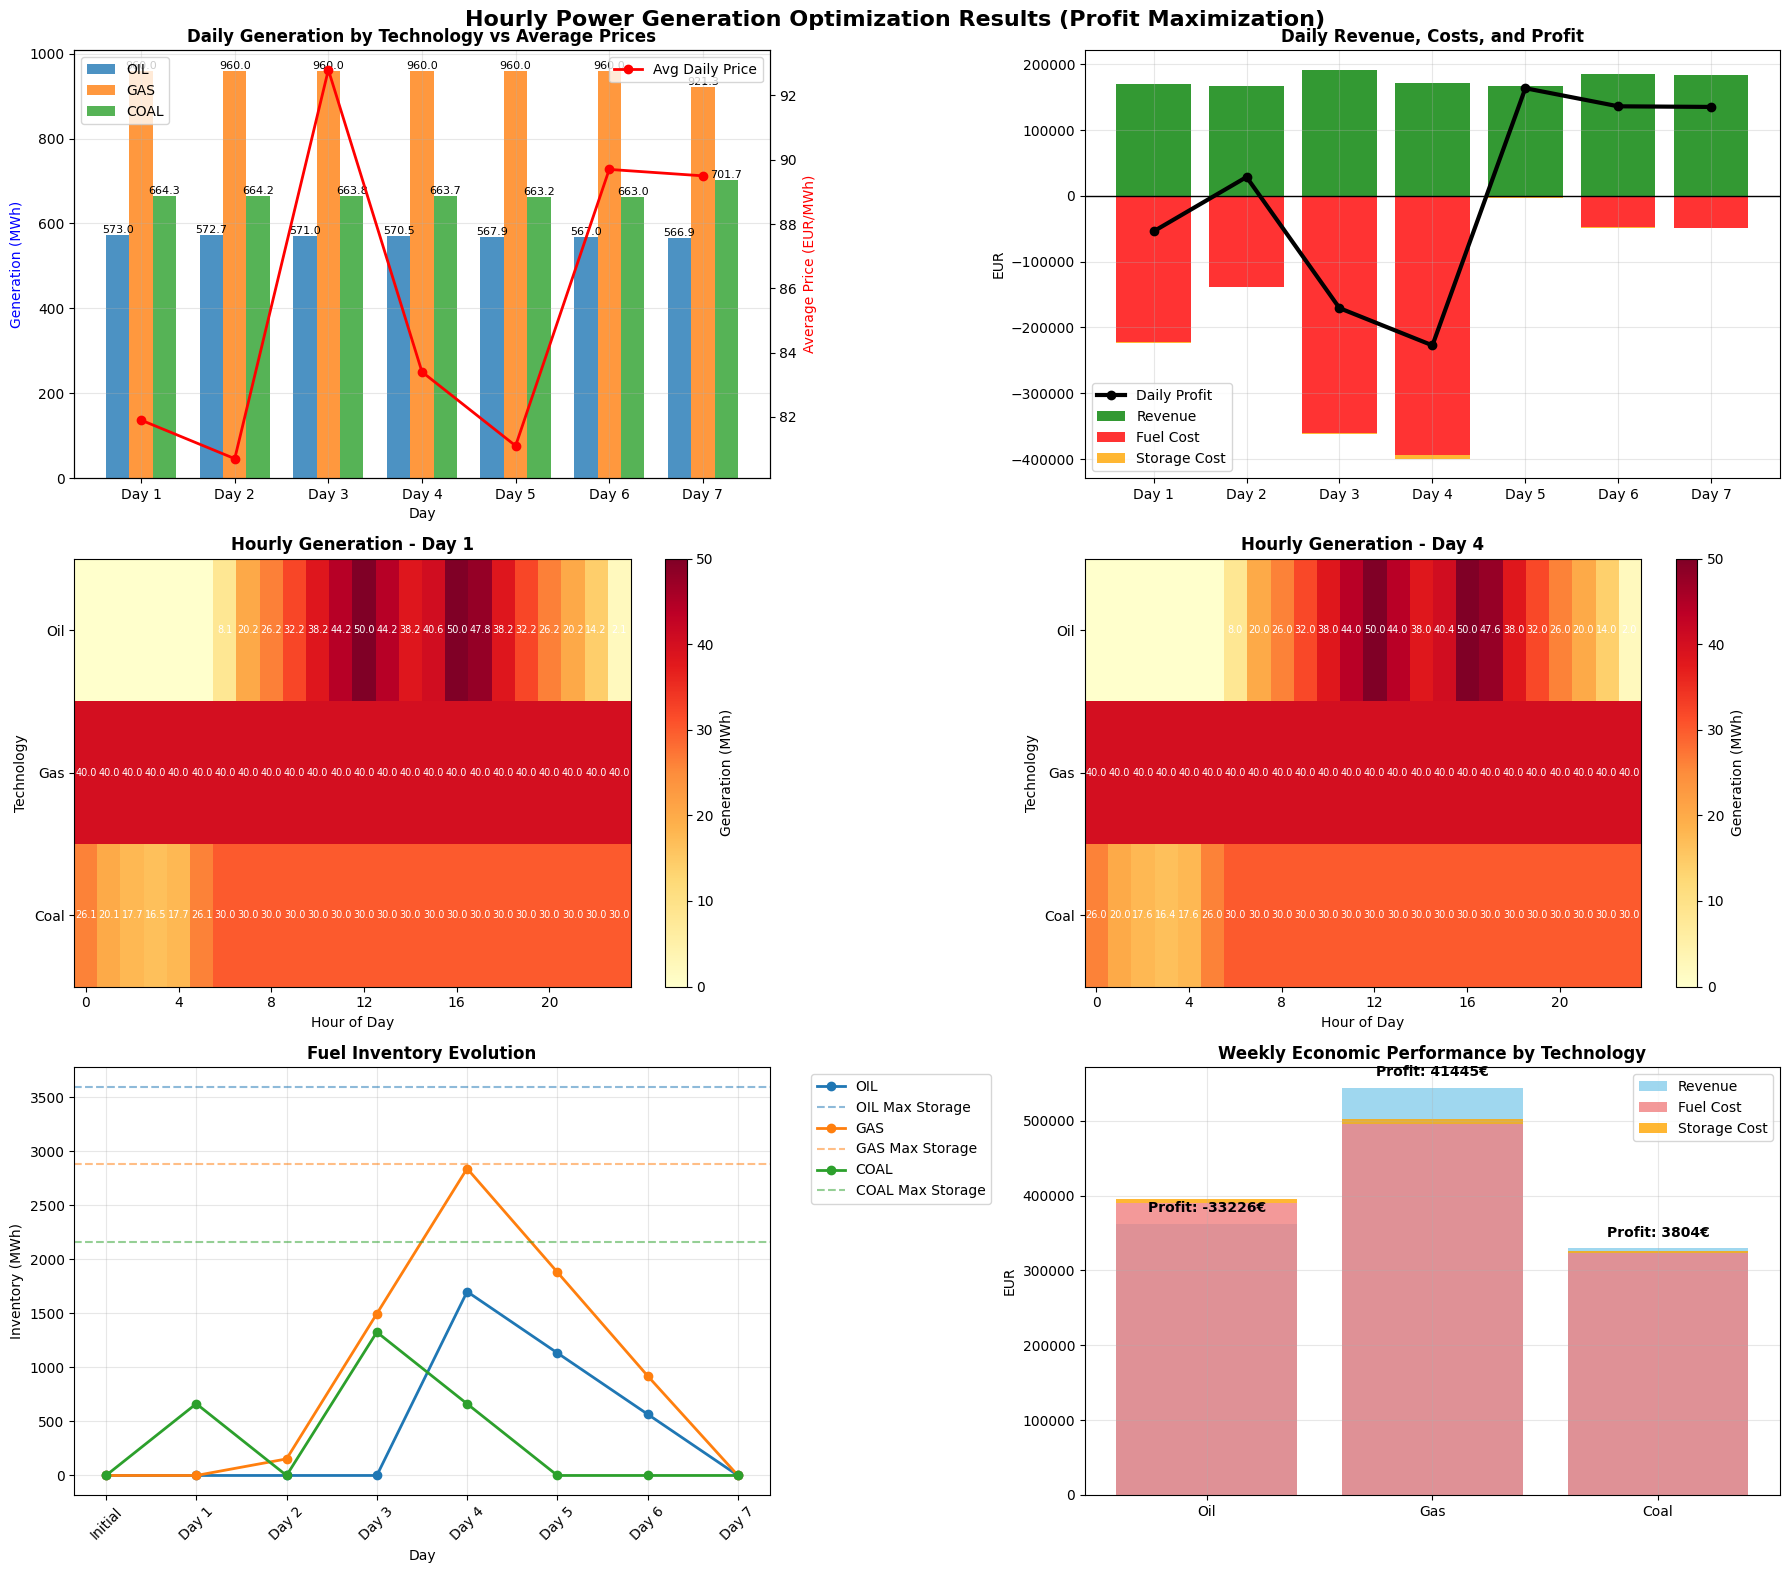

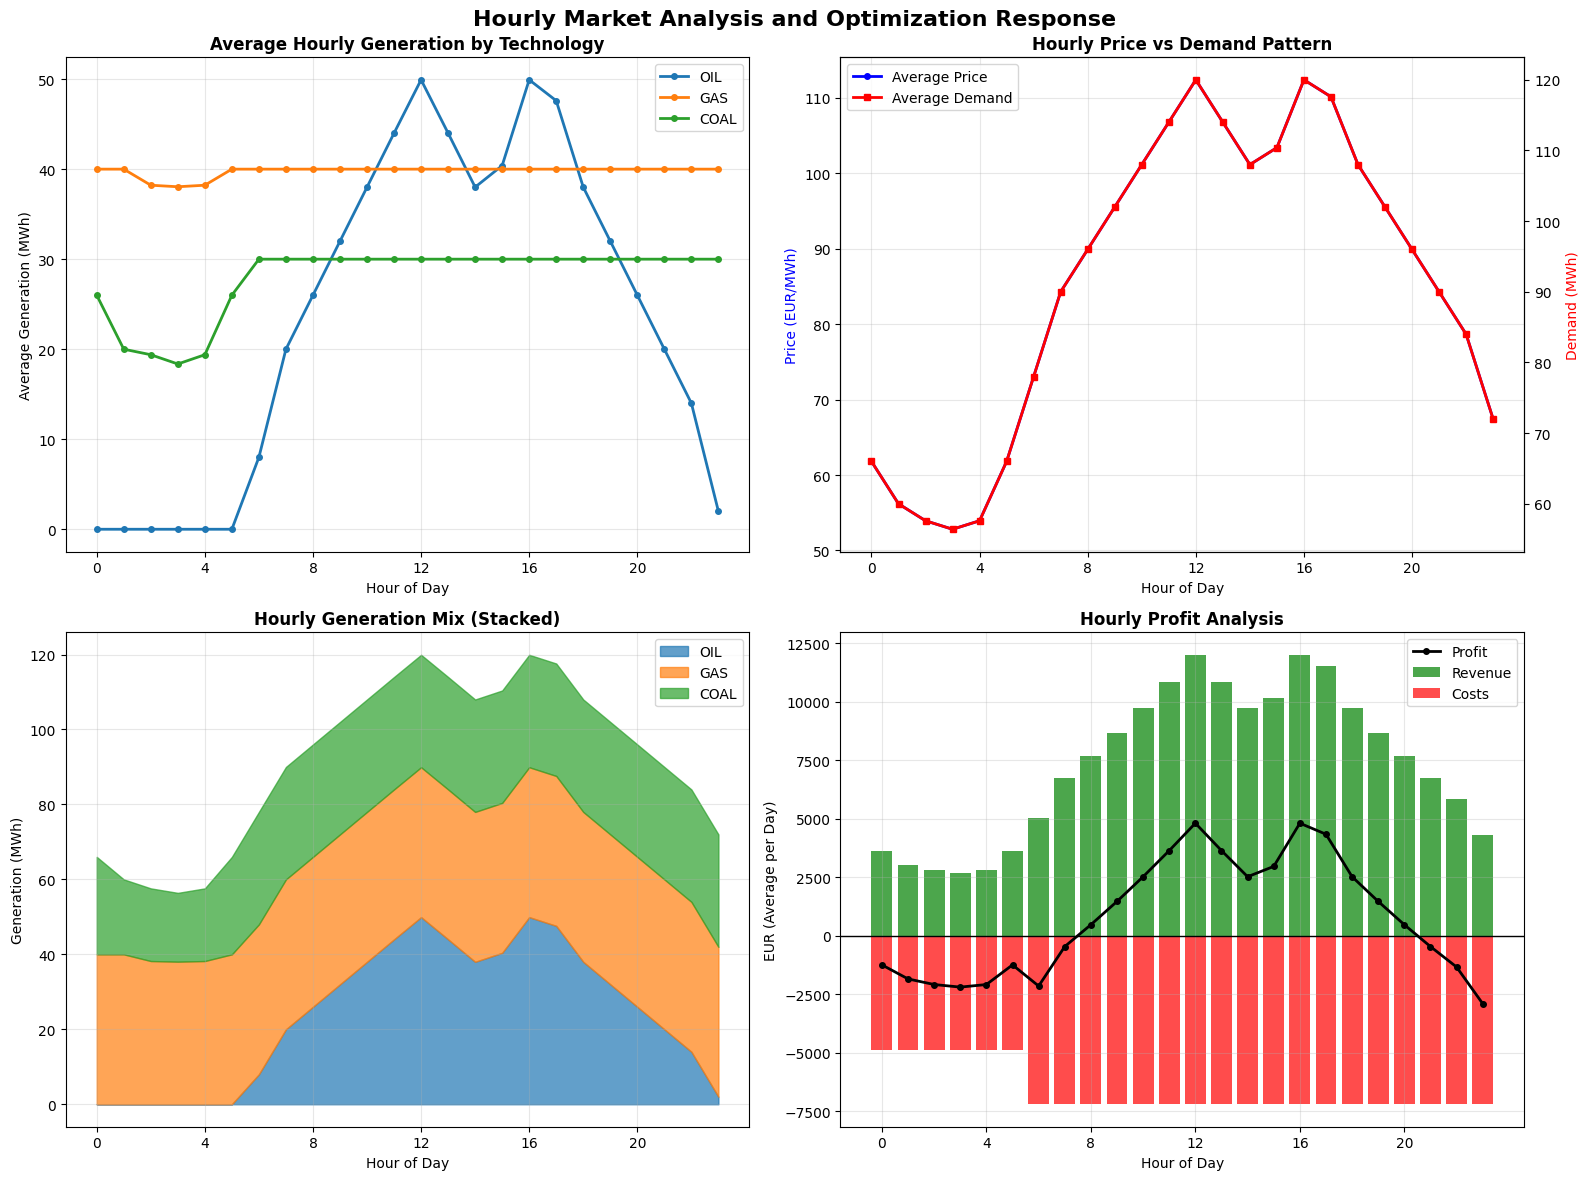


HOURLY OPTIMIZATION RESULTS SUMMARY

Weekly Performance:
  Total Revenue: 1236163.25 EUR
  Total Fuel Cost: 1209617.84 EUR
  Total Storage Cost: 14521.84 EUR
  Total Profit: 12023.58 EUR
  Profit Margin: 1.0%

Technology Performance:
  OIL:
    Total Generation: 3988.92 MWh
    Capacity Utilization: 47.5%
    Revenue: 362460.07 EUR
    Profit: -33225.66 EUR
    Profit Margin: -9.2%
  GAS:
    Total Generation: 6681.31 MWh
    Capacity Utilization: 99.4%
    Revenue: 544320.58 EUR
    Profit: 41445.45 EUR
    Profit Margin: 7.6%
  COAL:
    Total Generation: 4683.89 MWh
    Capacity Utilization: 92.9%
    Revenue: 329382.61 EUR
    Profit: 3803.79 EUR
    Profit Margin: 1.2%

Hourly Insights:
  Peak price hour: 12:00 (112.37 EUR/MWh)
  Off-peak price hour: 3:00 (52.81 EUR/MWh)
  Maximum generation hour: 12:00 (119.92 MWh)
  Price volatility: 20.23 EUR/MWh (std dev)


In [10]:
# -------------------------------------------------------
# Visualization of Hourly Optimization Results
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Extract solution data
    purchase_data = {}
    generate_data = {}
    inventory_data = {}
    hourly_generate_data = {}
    
    for t in TECHS:
        purchase_data[t] = []
        generate_data[t] = []
        inventory_data[t] = []
        hourly_generate_data[t] = []
        
        for d in DAYS:
            # Daily totals
            total_purchase = sum(purchase[t, s, d].X for s in SUPPLIERS[t])
            daily_generation = sum(generate[t, d, h].X for h in HOURS)
            
            purchase_data[t].append(total_purchase)
            generate_data[t].append(daily_generation)
            inventory_data[t].append(inventory[t, d].X)
            
            # Hourly generation data
            hourly_gen = [generate[t, d, h].X for h in HOURS]
            hourly_generate_data[t].append(hourly_gen)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Hourly Power Generation Optimization Results (Profit Maximization)', fontsize=16, fontweight='bold')
    
    days_labels = [f'Day {d+1}' for d in DAYS]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # 1. Daily Generation vs Prices
    ax1 = axes[0, 0]
    width = 0.25
    x = np.arange(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        bars = ax1.bar(x + i*width, generate_data[tech], width, 
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Add daily electricity prices on secondary axis
    ax1_twin = ax1.twinx()
    daily_avg_prices = [np.mean(elec_price_hourly[d]) for d in DAYS]
    ax1_twin.plot(x + width, daily_avg_prices, 'ro-', linewidth=2, markersize=6,
                 label='Avg Daily Price')
    
    ax1.set_title('Daily Generation by Technology vs Average Prices', fontweight='bold')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Generation (MWh)', color='blue')
    ax1_twin.set_ylabel('Average Price (EUR/MWh)', color='red')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(days_labels)
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Revenue and Cost Breakdown
    ax2 = axes[0, 1]
    
    # Calculate daily components
    daily_revenue = []
    daily_fuel_cost = []
    daily_storage_cost = []
    
    for d in DAYS:
        # Daily revenue
        day_revenue = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X
            for t in TECHS for h in HOURS
        )
        daily_revenue.append(day_revenue)
        
        # Daily fuel cost
        day_fuel_cost = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for t in TECHS for s in SUPPLIERS[t]
        )
        daily_fuel_cost.append(day_fuel_cost)
        
        # Daily storage cost
        day_storage_cost = sum(
            storage_rent[t] * inventory[t, d].X
            for t in TECHS
        )
        daily_storage_cost.append(day_storage_cost)
    
    # Plot stacked costs vs revenue
    ax2.bar(days_labels, daily_revenue, label='Revenue', color='green', alpha=0.8)
    ax2.bar(days_labels, [-cost for cost in daily_fuel_cost], label='Fuel Cost', 
           color='red', alpha=0.8)
    ax2.bar(days_labels, [-cost for cost in daily_storage_cost], 
           bottom=[-cost for cost in daily_fuel_cost],
           label='Storage Cost', color='orange', alpha=0.8)
    
    # Add daily profit line
    daily_profit = [rev - fuel - storage for rev, fuel, storage in 
                   zip(daily_revenue, daily_fuel_cost, daily_storage_cost)]
    ax2.plot(days_labels, daily_profit, 'ko-', linewidth=3, markersize=6,
            label='Daily Profit')
    
    ax2.set_title('Daily Revenue, Costs, and Profit', fontweight='bold')
    ax2.set_ylabel('EUR')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # 3. Hourly Generation Heatmap for Day 0 and Day 3 (sample days)
    for day_idx, sample_day in enumerate([0, 3]):
        if sample_day < num_days:
            ax3 = axes[1, day_idx]
            
            # Create generation matrix for heatmap
            gen_matrix = []
            for t in TECHS:
                hourly_gen = [generate[t, sample_day, h].X for h in HOURS]
                gen_matrix.append(hourly_gen)
            
            gen_matrix = np.array(gen_matrix)
            
            im = ax3.imshow(gen_matrix, cmap='YlOrRd', aspect='auto')
            ax3.set_title(f'Hourly Generation - Day {sample_day + 1}', fontweight='bold')
            ax3.set_xlabel('Hour of Day')
            ax3.set_ylabel('Technology')
            ax3.set_xticks(range(0, 24, 4))
            ax3.set_yticks(range(len(TECHS)))
            ax3.set_yticklabels(TECHS)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3)
            cbar.set_label('Generation (MWh)')
            
            # Add text annotations for non-zero values
            for i in range(len(TECHS)):
                for j in range(num_hours):
                    if gen_matrix[i, j] > 0.01:
                        ax3.text(j, i, f'{gen_matrix[i, j]:.1f}', 
                               ha='center', va='center', fontsize=7, color='white')
    
    # 4. Inventory Evolution
    ax4 = axes[2, 0]
    for i, tech in enumerate(TECHS):
        # Add initial inventory as day 0
        inv_with_initial = [init_inventory[tech]] + inventory_data[tech]
        days_with_initial = ['Initial'] + days_labels
        
        ax4.plot(days_with_initial, inv_with_initial, 
                marker='o', linewidth=2, markersize=6,
                label=tech.upper(), color=colors[i])
        
        # Add storage capacity limit
        ax4.axhline(y=storage_cap[tech], color=colors[i], 
                   linestyle='--', alpha=0.5, 
                   label=f'{tech.upper()} Max Storage')
    
    ax4.set_title('Fuel Inventory Evolution', fontweight='bold')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Inventory (MWh)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Merit Order Analysis
    ax5 = axes[2, 1]
    
    # Calculate technology-level economics
    tech_revenues = {}
    tech_fuel_costs = {}
    tech_storage_costs = {}
    tech_profits = {}
    
    for t in TECHS:
        # Total revenue by technology
        tech_revenue = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X
            for d in DAYS for h in HOURS
        )
        tech_revenues[t] = tech_revenue
        
        # Total fuel costs by technology
        tech_fuel_cost = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for s in SUPPLIERS[t] for d in DAYS
        )
        tech_fuel_costs[t] = tech_fuel_cost
        
        # Total storage costs by technology
        tech_storage_cost = sum(
            storage_rent[t] * inventory[t, d].X
            for d in DAYS
        )
        tech_storage_costs[t] = tech_storage_cost
        
        # Technology profit
        tech_profits[t] = tech_revenue - tech_fuel_cost - tech_storage_cost
    
    # Create stacked bar chart
    revenues = [tech_revenues[t] for t in TECHS]
    fuel_costs = [tech_fuel_costs[t] for t in TECHS]
    storage_costs = [tech_storage_costs[t] for t in TECHS]
    profits = [tech_profits[t] for t in TECHS]
    
    bars1 = ax5.bar(TECHS, revenues, label='Revenue', color='skyblue', alpha=0.8)
    bars2 = ax5.bar(TECHS, fuel_costs, bottom=[0]*len(TECHS), 
                   label='Fuel Cost', color='lightcoral', alpha=0.8)
    bars3 = ax5.bar(TECHS, storage_costs, bottom=fuel_costs, 
                   label='Storage Cost', color='orange', alpha=0.8)
    
    # Add profit values as text
    for i, (tech, profit) in enumerate(zip(TECHS, profits)):
        ax5.text(i, revenues[i] + max(revenues)*0.02, f'Profit: {profit:.0f}€', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax5.set_title('Weekly Economic Performance by Technology', fontweight='bold')
    ax5.set_ylabel('EUR')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Hourly Analysis for Peak and Off-Peak Hours
    # -------------------------------------------------------
    
    # Create additional figure for hourly analysis
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('Hourly Market Analysis and Optimization Response', fontsize=16, fontweight='bold')
    
    # 1. Average Hourly Generation by Technology
    ax2_1 = axes2[0, 0]
    
    # Calculate average hourly generation across all days
    avg_hourly_gen = {}
    for t in TECHS:
        avg_hourly_gen[t] = []
        for h in HOURS:
            avg_gen = np.mean([generate[t, d, h].X for d in DAYS])
            avg_hourly_gen[t].append(avg_gen)
    
    for i, tech in enumerate(TECHS):
        ax2_1.plot(HOURS, avg_hourly_gen[tech], label=tech.upper(), 
                  color=colors[i], linewidth=2, marker='o', markersize=4)
    
    ax2_1.set_title('Average Hourly Generation by Technology', fontweight='bold')
    ax2_1.set_xlabel('Hour of Day')
    ax2_1.set_ylabel('Average Generation (MWh)')
    ax2_1.legend()
    ax2_1.grid(True, alpha=0.3)
    ax2_1.set_xticks(range(0, 24, 4))
    
    # 2. Price-Generation Correlation
    ax2_2 = axes2[0, 1]
    
    # Average hourly prices and total generation
    avg_hourly_price = [np.mean([elec_price_hourly[d][h] for d in DAYS]) for h in HOURS]
    avg_hourly_total_gen = [sum(avg_hourly_gen[t][h] for t in TECHS) for h in HOURS]
    avg_hourly_demand = [np.mean([hourly_demand[d][h] for d in DAYS]) for h in HOURS]
    
    ax2_2_twin = ax2_2.twinx()
    
    line1 = ax2_2.plot(HOURS, avg_hourly_price, 'b-o', linewidth=2, markersize=4,
                      label='Average Price')
    line2 = ax2_2_twin.plot(HOURS, avg_hourly_demand, 'r-s', linewidth=2, markersize=4,
                           label='Average Demand')
    
    ax2_2.set_title('Hourly Price vs Demand Pattern', fontweight='bold')
    ax2_2.set_xlabel('Hour of Day')
    ax2_2.set_ylabel('Price (EUR/MWh)', color='blue')
    ax2_2_twin.set_ylabel('Demand (MWh)', color='red')
    ax2_2.set_xticks(range(0, 24, 4))
    ax2_2.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2_2.legend(lines, labels, loc='upper left')
    
    # 3. Technology Merit Order Response
    ax2_3 = axes2[1, 0]
    
    # Show which technology is most active at different hours
    tech_dominance = []
    for h in HOURS:
        hour_gen = {t: avg_hourly_gen[t][h] for t in TECHS}
        dominant_tech = max(hour_gen, key=hour_gen.get) if max(hour_gen.values()) > 0.01 else None
        tech_dominance.append(dominant_tech)
    
    # Create stacked area chart
    bottom = np.zeros(num_hours)
    for i, tech in enumerate(TECHS):
        values = avg_hourly_gen[tech]
        ax2_3.fill_between(HOURS, bottom, bottom + values, 
                          label=tech.upper(), color=colors[i], alpha=0.7)
        bottom += values
    
    ax2_3.set_title('Hourly Generation Mix (Stacked)', fontweight='bold')
    ax2_3.set_xlabel('Hour of Day')
    ax2_3.set_ylabel('Generation (MWh)')
    ax2_3.legend()
    ax2_3.grid(True, alpha=0.3)
    ax2_3.set_xticks(range(0, 24, 4))
    
    # 4. Profit Margins by Hour
    ax2_4 = axes2[1, 1]
    
    # Calculate hourly profit margins
    hourly_revenue = []
    hourly_costs = []
    
    for h in HOURS:
        # Average hourly revenue across all days
        hour_rev = np.mean([
            sum(elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X 
                for t in TECHS) for d in DAYS
        ])
        hourly_revenue.append(hour_rev)
        
        # Estimate hourly fuel costs (proportional to generation)
        total_daily_gen = {t: sum(generate[t, d, h].X for d in DAYS for h_all in HOURS) for t in TECHS}
        hour_gen = {t: sum(generate[t, d, h].X for d in DAYS) for t in TECHS}
        
        hour_cost = 0
        for t in TECHS:
            if total_daily_gen[t] > 0:
                # Proportional fuel cost allocation
                fuel_cost_share = hour_gen[t] / total_daily_gen[t] if total_daily_gen[t] > 0 else 0
                total_tech_fuel_cost = sum(
                    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
                    for s in SUPPLIERS[t] for d in DAYS
                )
                hour_cost += fuel_cost_share * total_tech_fuel_cost
        
        hourly_costs.append(hour_cost / num_days)  # Average per day
    
    hourly_profit = [rev - cost for rev, cost in zip(hourly_revenue, hourly_costs)]
    
    ax2_4.bar(HOURS, hourly_revenue, alpha=0.7, label='Revenue', color='green')
    ax2_4.bar(HOURS, [-cost for cost in hourly_costs], alpha=0.7, label='Costs', color='red')
    ax2_4.plot(HOURS, hourly_profit, 'ko-', linewidth=2, markersize=4, label='Profit')
    
    ax2_4.set_title('Hourly Profit Analysis', fontweight='bold')
    ax2_4.set_xlabel('Hour of Day')
    ax2_4.set_ylabel('EUR (Average per Day)')
    ax2_4.legend()
    ax2_4.grid(True, alpha=0.3)
    ax2_4.set_xticks(range(0, 24, 4))
    ax2_4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*80)
    print("HOURLY OPTIMIZATION RESULTS SUMMARY")
    print("="*80)
    
    total_revenue = sum(tech_revenues.values())
    total_fuel_cost = sum(tech_fuel_costs.values())
    total_storage_cost = sum(tech_storage_costs.values())
    total_profit = total_revenue - total_fuel_cost - total_storage_cost
    
    print(f"\nWeekly Performance:")
    print(f"  Total Revenue: {total_revenue:.2f} EUR")
    print(f"  Total Fuel Cost: {total_fuel_cost:.2f} EUR")
    print(f"  Total Storage Cost: {total_storage_cost:.2f} EUR")
    print(f"  Total Profit: {total_profit:.2f} EUR")
    print(f"  Profit Margin: {100*total_profit/total_revenue:.1f}%")
    
    print(f"\nTechnology Performance:")
    for t in TECHS:
        tech_generation = sum(sum(generate[t, d, h].X for h in HOURS) for d in DAYS)
        tech_capacity_utilization = tech_generation / (max_gen[t] * num_days * num_hours) * 100
        tech_profit_margin = tech_profits[t] / tech_revenues[t] * 100 if tech_revenues[t] > 0 else 0
        
        print(f"  {t.upper()}:")
        print(f"    Total Generation: {tech_generation:.2f} MWh")
        print(f"    Capacity Utilization: {tech_capacity_utilization:.1f}%")
        print(f"    Revenue: {tech_revenues[t]:.2f} EUR")
        print(f"    Profit: {tech_profits[t]:.2f} EUR")
        print(f"    Profit Margin: {tech_profit_margin:.1f}%")
    
    print(f"\nHourly Insights:")
    peak_hour = np.argmax(avg_hourly_price)
    off_peak_hour = np.argmin(avg_hourly_price)
    max_gen_hour = np.argmax(avg_hourly_total_gen)
    
    print(f"  Peak price hour: {peak_hour}:00 ({avg_hourly_price[peak_hour]:.2f} EUR/MWh)")
    print(f"  Off-peak price hour: {off_peak_hour}:00 ({avg_hourly_price[off_peak_hour]:.2f} EUR/MWh)")
    print(f"  Maximum generation hour: {max_gen_hour}:00 ({avg_hourly_total_gen[max_gen_hour]:.2f} MWh)")
    print(f"  Price volatility: {np.std(avg_hourly_price):.2f} EUR/MWh (std dev)")

    

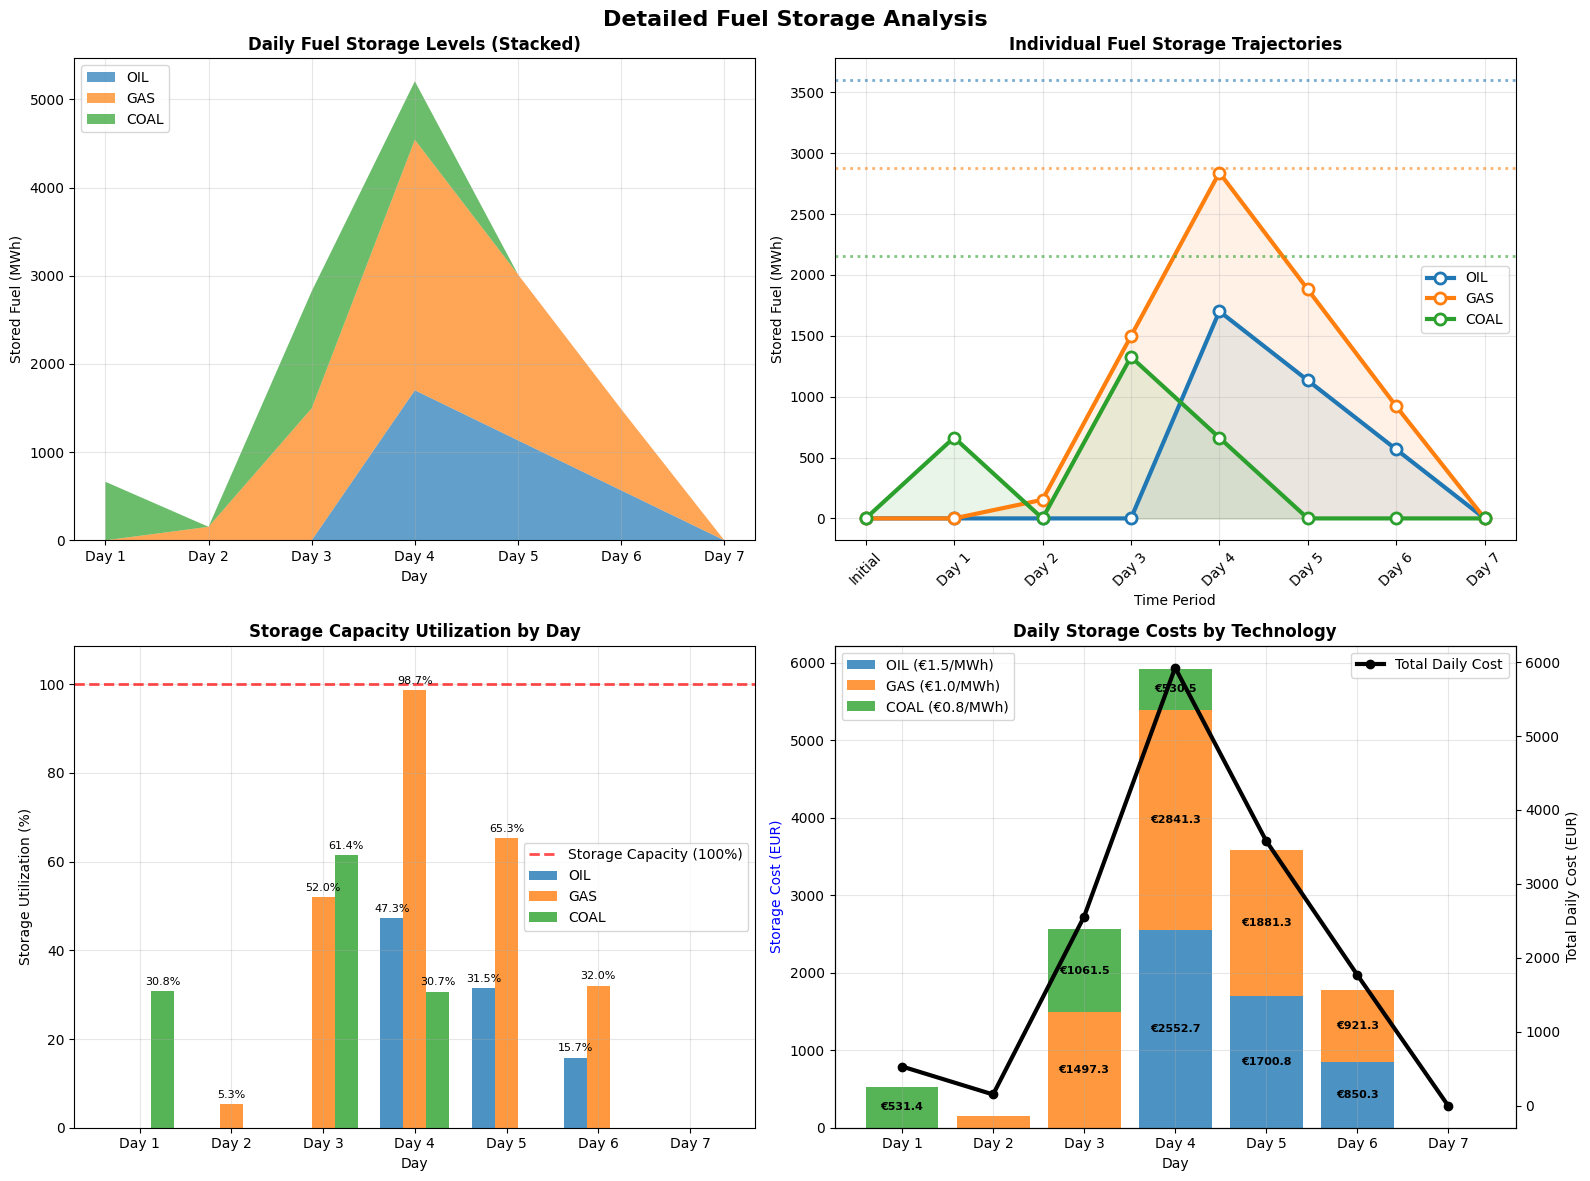


FUEL STORAGE ANALYSIS SUMMARY

Storage Capacity and Utilization:
  OIL:
    Storage Capacity: 3600.0 MWh
    Storage Rent: €1.5/MWh/day
    Average Storage Used: 486.1 MWh (13.5%)
    Maximum Storage Used: 1701.8 MWh (47.3%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €5103.86
  GAS:
    Storage Capacity: 2880.0 MWh
    Storage Rent: €1.0/MWh/day
    Average Storage Used: 1042.1 MWh (36.2%)
    Maximum Storage Used: 2841.3 MWh (98.7%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €7294.54
  COAL:
    Storage Capacity: 2160.0 MWh
    Storage Rent: €0.8/MWh/day
    Average Storage Used: 379.2 MWh (17.6%)
    Maximum Storage Used: 1326.9 MWh (61.4%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €2123.43

Overall Storage Economics:
  Total Storage Investment (if fully utilized): €70056.00
  Actual Storage Costs: €14521.84
  Storage Cost Efficiency: 20.7%

Storage Strategy Insights:
  Most stable storage: COAL (std dev: 483.3 MWh)
  Most volatile stora

In [11]:
# -------------------------------------------------------
# Detailed Fuel Storage Analysis
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Create dedicated figure for fuel storage analysis
    fig_storage, axes_storage = plt.subplots(2, 2, figsize=(16, 12))
    fig_storage.suptitle('Detailed Fuel Storage Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    days_labels = [f'Day {d+1}' for d in DAYS]
    
    # 1. Daily Fuel Storage Levels (Stacked Area Chart)
    ax_s1 = axes_storage[0, 0]
    
    # Prepare data for stacked area chart
    storage_matrix = []
    for t in TECHS:
        storage_matrix.append(inventory_data[t])
    storage_matrix = np.array(storage_matrix)
    
    # Create stacked area chart
    ax_s1.stackplot(range(len(DAYS)), *storage_matrix, 
                   labels=[t.upper() for t in TECHS], 
                   colors=colors, alpha=0.7)
    

    
    ax_s1.set_title('Daily Fuel Storage Levels (Stacked)', fontweight='bold')
    ax_s1.set_xlabel('Day')
    ax_s1.set_ylabel('Stored Fuel (MWh)')
    ax_s1.set_xticks(range(len(DAYS)))
    ax_s1.set_xticklabels(days_labels)
    ax_s1.legend(loc='upper left')
    ax_s1.grid(True, alpha=0.3)
    
    # 2. Individual Storage Trajectories
    ax_s2 = axes_storage[0, 1]
    
    for i, tech in enumerate(TECHS):
        # Include initial inventory
        storage_trajectory = [init_inventory[tech]] + inventory_data[tech]
        days_with_init = ['Initial'] + days_labels
        
        # Plot storage trajectory
        line = ax_s2.plot(range(len(storage_trajectory)), storage_trajectory, 
                         'o-', linewidth=3, markersize=8, label=tech.upper(), 
                         color=colors[i], markerfacecolor='white', 
                         markeredgecolor=colors[i], markeredgewidth=2)
        
        # Add storage capacity as horizontal line
        ax_s2.axhline(y=storage_cap[tech], color=colors[i], 
                     linestyle=':', alpha=0.6, linewidth=2)
        
        # Fill area under curve
        ax_s2.fill_between(range(len(storage_trajectory)), 0, storage_trajectory, 
                          alpha=0.1, color=colors[i])
    
    ax_s2.set_title('Individual Fuel Storage Trajectories', fontweight='bold')
    ax_s2.set_xlabel('Time Period')
    ax_s2.set_ylabel('Stored Fuel (MWh)')
    ax_s2.set_xticks(range(len(days_with_init)))
    ax_s2.set_xticklabels(days_with_init, rotation=45)
    ax_s2.legend()
    ax_s2.grid(True, alpha=0.3)
    
    # 3. Storage Utilization Rate
    ax_s3 = axes_storage[1, 0]
    
    # Calculate storage utilization for each technology and day
    utilization_data = {}
    for t in TECHS:
        utilization_data[t] = [(inv / storage_cap[t]) * 100 for inv in inventory_data[t]]
    
    # Create grouped bar chart
    x = np.arange(len(DAYS))
    width = 0.25
    
    for i, tech in enumerate(TECHS):
        bars = ax_s3.bar(x + i*width, utilization_data[tech], width, 
                        label=tech.upper(), color=colors[i], alpha=0.8)
        
        # Add percentage labels on bars
        for bar, util in zip(bars, utilization_data[tech]):
            if util > 1:  # Only show labels for visible bars
                ax_s3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                          f'{util:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax_s3.axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                 label='Storage Capacity (100%)')
    ax_s3.set_title('Storage Capacity Utilization by Day', fontweight='bold')
    ax_s3.set_xlabel('Day')
    ax_s3.set_ylabel('Storage Utilization (%)')
    ax_s3.set_xticks(x + width)
    ax_s3.set_xticklabels(days_labels)
    ax_s3.legend()
    ax_s3.grid(True, alpha=0.3)
    ax_s3.set_ylim(0, max(max(utilization_data[t]) for t in TECHS) + 10)
    
    # 4. Storage Cost Analysis
    ax_s4 = axes_storage[1, 1]
    
    # Calculate daily storage costs for each technology
    daily_storage_costs_by_tech = {}
    total_daily_storage_costs = []
    
    for t in TECHS:
        daily_storage_costs_by_tech[t] = []
        
    for d in DAYS:
        day_total_cost = 0
        for t in TECHS:
            daily_cost = storage_rent[t] * inventory_data[t][d]
            daily_storage_costs_by_tech[t].append(daily_cost)
            day_total_cost += daily_cost
        total_daily_storage_costs.append(day_total_cost)
    
    # Create stacked bar chart for storage costs
    bottom_costs = np.zeros(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        costs = daily_storage_costs_by_tech[tech]
        bars = ax_s4.bar(days_labels, costs, bottom=bottom_costs,
                        label=f'{tech.upper()} (€{storage_rent[tech]}/MWh)', 
                        color=colors[i], alpha=0.8)
        
        # Add cost labels for significant values
        for j, (bar, cost) in enumerate(zip(bars, costs)):
            if cost > max(total_daily_storage_costs) * 0.05:  # Show labels > 5% of max
                ax_s4.text(bar.get_x() + bar.get_width()/2., 
                          bottom_costs[j] + cost/2,
                          f'€{cost:.1f}', ha='center', va='center', 
                          fontsize=8, fontweight='bold')
        
        bottom_costs += costs
    
    # Add total cost line
    ax_s4_twin = ax_s4.twinx()
    ax_s4_twin.plot(days_labels, total_daily_storage_costs, 'ko-', 
                   linewidth=3, markersize=6, label='Total Daily Cost')
    
    ax_s4.set_title('Daily Storage Costs by Technology', fontweight='bold')
    ax_s4.set_xlabel('Day')
    ax_s4.set_ylabel('Storage Cost (EUR)', color='blue')
    ax_s4_twin.set_ylabel('Total Daily Cost (EUR)', color='black')
    ax_s4.legend(loc='upper left')
    ax_s4_twin.legend(loc='upper right')
    ax_s4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Storage Summary Statistics
    # -------------------------------------------------------
    
    print("\n" + "="*80)
    print("FUEL STORAGE ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nStorage Capacity and Utilization:")
    for t in TECHS:
        max_storage_used = max(inventory_data[t])
        min_storage_used = min(inventory_data[t])
        avg_storage_used = np.mean(inventory_data[t])
        avg_utilization = (avg_storage_used / storage_cap[t]) * 100
        max_utilization = (max_storage_used / storage_cap[t]) * 100
        
        total_storage_cost = sum(storage_rent[t] * inv for inv in inventory_data[t])
        
        print(f"  {t.upper()}:")
        print(f"    Storage Capacity: {storage_cap[t]:.1f} MWh")
        print(f"    Storage Rent: €{storage_rent[t]:.1f}/MWh/day")
        print(f"    Average Storage Used: {avg_storage_used:.1f} MWh ({avg_utilization:.1f}%)")
        print(f"    Maximum Storage Used: {max_storage_used:.1f} MWh ({max_utilization:.1f}%)")
        print(f"    Minimum Storage Used: {min_storage_used:.1f} MWh")
        print(f"    Total Storage Cost: €{total_storage_cost:.2f}")
    
    print(f"\nOverall Storage Economics:")
    total_storage_investment = sum(storage_cap[t] * storage_rent[t] for t in TECHS) * num_days
    total_storage_cost_actual = sum(sum(daily_storage_costs_by_tech[t]) for t in TECHS)
    storage_cost_efficiency = (total_storage_cost_actual / total_storage_investment) * 100
    
    print(f"  Total Storage Investment (if fully utilized): €{total_storage_investment:.2f}")
    print(f"  Actual Storage Costs: €{total_storage_cost_actual:.2f}")
    print(f"  Storage Cost Efficiency: {storage_cost_efficiency:.1f}%")
    
    # Storage strategy insights
    print(f"\nStorage Strategy Insights:")
    
    # Find which technology has most consistent storage
    storage_volatility = {}
    for t in TECHS:
        storage_volatility[t] = np.std(inventory_data[t])
    
    most_stable = min(storage_volatility, key=storage_volatility.get)
    most_volatile = max(storage_volatility, key=storage_volatility.get)
    
    print(f"  Most stable storage: {most_stable.upper()} (std dev: {storage_volatility[most_stable]:.1f} MWh)")
    print(f"  Most volatile storage: {most_volatile.upper()} (std dev: {storage_volatility[most_volatile]:.1f} MWh)")
    
    # Storage trend analysis
    for t in TECHS:
        if len(inventory_data[t]) > 1:
            trend_slope = np.polyfit(range(len(inventory_data[t])), inventory_data[t], 1)[0]
            if trend_slope > 0.1:
                trend = "increasing"
            elif trend_slope < -0.1:
                trend = "decreasing"
            else:
                trend = "stable"
            print(f"  {t.upper()} storage trend: {trend} ({trend_slope:+.2f} MWh/day)")

else:
    print("No optimal solution found - cannot create storage analysis plots")

# Draft 3

## Data loading

In [12]:
import json
import random
import itertools
import random

random.seed(42)  # reproducible

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
num_hours = 24

TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

import random

DAY_TYPES = ["Base", "Spike", "Severe"]

# Tech-specific probabilities for each day type
# (example: gas more volatile, coal more stable)
day_type_prob_by_tech = {
    "Oil":  {"Base": 0.7, "Spike": 0.2, "Severe": 0.1},
    "Gas":  {"Base": 0.6, "Spike": 0.25, "Severe": 0.15},
    "Coal": {"Base": 0.8, "Spike": 0.15, "Severe": 0.05}
}

num_scenarios = 30  # you already use 30 weeks

scenario_names = [f"Week_{i}" for i in range(num_scenarios)]
scenario_day_types = {}       # scen -> tech -> [day_type per day]
scenario_probs_raw = []       # one raw probability per scenario

for scen_idx, scen_name in enumerate(scenario_names):
    scenario_day_types[scen_name] = {}
    prob_raw = 1.0

    for t in TECHS:
        probs_t = day_type_prob_by_tech[t]
        # precompute cumulative for sampling
        cum_base = probs_t["Base"]
        cum_spike = cum_base + probs_t["Spike"]
        pattern_t = []

        for d in range(num_days):
            if scen_idx == 0 and t == "Oil" and d == 0:
                # Example: fix something in Week_0 just to have a nice pattern
                # (this is optional; you can also do everything random)
                dt = "Base"
            else:
                r = random.random()
                if r < cum_base:
                    dt = "Base"
                elif r < cum_spike:
                    dt = "Spike"
                else:
                    dt = "Severe"

            pattern_t.append(dt)
            prob_raw *= probs_t[dt]   # accumulate raw probability

        scenario_day_types[scen_name][t] = pattern_t

    scenario_probs_raw.append(prob_raw)

# Normalize scenario probabilities so they sum to 1
total_prob = sum(scenario_probs_raw)
scenario_prob = {
    scenario_names[i]: scenario_probs_raw[i] / total_prob
    for i in range(num_scenarios)
}
# ---------------------------

# Hourly factors shape; peak around midday / evening.
hourly_factors = [
    0.55, 0.50, 0.48, 0.47, 0.48, 0.55,  # 0-5: low night
    0.65, 0.75, 0.80, 0.85, 0.90, 0.95,  # 6-11: ramp up
    1.00, 0.95, 0.90, 0.92, 1.00, 0.98,  # 12-17: high / evening peak
    0.90, 0.85, 0.80, 0.75, 0.70, 0.60   # 18-23: decline
]
assert len(hourly_factors) == num_hours
avg_hour_factors = sum(hourly_factors) / num_hours

# Max generation & storage (interpret as *hourly* max power)
max_gen = {"Oil": 50.0, "Gas": 40.0, "Coal": 30.0}

# Weekly demand target (approx)
weekly_demand_target = sum(max_gen[i] for i in max_gen) * avg_hour_factors * num_hours * num_days # MWh

storage_cap = {"Oil": max_gen["Oil"]*24*3, "Gas": max_gen["Gas"]*24*3, "Coal": max_gen["Coal"]*24*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# =====================================================
# Helper: volatile path generator (for prices)
# =====================================================
def generate_price_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Generate a volatile path with Gaussian noise and occasional *upward* spikes.
    Used for fuel and electricity prices.
    """
    prices = []
    level = base
    for d in range(days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional upward spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_low, spike_high)
            level += spike

        # avoid negative or too low prices
        level = max(5.0, level)
        prices.append(round(level, 1))
    return prices


# =====================================================
# 1) Fuel bids with volatility & spikes (daily auctions)
# =====================================================
fuel_bids = {}

tech_config = {
    "Coal": {
        "base_price": 65.0,  # €/MWh, cheapest
        "daily_vol": 3.0,
        "spike_prob": 0.05,
        "spike_low": 5.0,
        "spike_high": 5.0,
    },
    "Gas": {
        "base_price": 80.0,  # €/MWh, mid
        "daily_vol": 5.0,
        "spike_prob": 0.05,
        "spike_low": 10.0,
        "spike_high": 10.0,
    },
    "Oil": {
        "base_price": 100.0,  # €/MWh, most expensive
        "daily_vol": 4.0,
        "spike_prob": 0.05,
        "spike_low": 10.0,
        "spike_high": 10.0,
    },
}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        premium = (idx - 1) * 3.0
        base = cfg["base_price"] + premium

        prices_by_scen = {}

        # Base scenario: as before
        base_prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_low=cfg["spike_low"],
            spike_high=cfg["spike_high"],
            days=num_days
        )
        prices_by_scen["Base"] = base_prices

        # Spike scenario: base + moderate uplift on some days
        spike_prices = [
            p + 25.0 if d in [2, 3, 4] else p + 25.0
            for d, p in enumerate(base_prices)
        ]
        prices_by_scen["Spike"] = spike_prices

        # Severe scenario: strong uplift
        severe_prices = [
            p + 70.0 if d in [2, 3, 4] else p + 70.0
            for d, p in enumerate(base_prices)
        ]
        prices_by_scen["Severe"] = severe_prices

        # Same max quantity for all scenarios (simplification)
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*num_hours*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            # IMPORTANT: now a dict: scen -> [prices per day]
            "price_EUR_per_MWh": prices_by_scen,
            "max_MWh_per_day": max_qty
        }



# =====================================================
# 3) Daily demand path with *downward* volatility
# =====================================================
def generate_downward_demand_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Volatile daily demand path mainly moving downward (e.g. due to RES, efficiency).
    - Negative bias in daily shocks
    - Occasional downward spikes
    - Then scaled so that weekly sum matches weekly_demand_target
    """
    demands = []
    level = base
    for d in range(days):
        # negative-biased shock
        shock = -abs(random.gauss(0, daily_vol))
        level += shock

        # occasional downward spike
        if random.random() < spike_prob:
            spike = -random.uniform(spike_low, spike_high)
            level += spike

        # avoid zero or negative demand
        level = max(0.1 * base, level)
        demands.append(level)

    # scale to match weekly target
    current_sum = sum(demands)
    scale = weekly_demand_target / current_sum
    demands = [round(d * scale, 3) for d in demands]
    return demands


base_daily = weekly_demand_target / num_days
daily_demand = generate_downward_demand_path(
    base=base_daily,
    daily_vol=1.0,
    spike_prob=0.20,
    spike_low=1.0,
    spike_high=3.0,
    days=num_days
)


# =====================================================
# Hourly demand factors and hourly demand (MWh)
# =====================================================


# Normalize so max factor = 1.0 (as per your “factor = 1” definition)
max_factor = max(hourly_factors)
hourly_factors = [round(x / max_factor, 3) for x in hourly_factors]
factor_sum = sum(hourly_factors)

# Compute hourly demand so that sum_h demand[d,h] = daily_demand[d]
hourly_demand = []
for d in range(num_days):
    day_row = []
    for h in range(num_hours):
        val = daily_demand[d] * (hourly_factors[h] / factor_sum)
        day_row.append(round(val, 4))
    hourly_demand.append(day_row)



# =====================================================
# 6) Revenue factors per technology (emission penalty)
# =====================================================
# Coal most penalized, gas least.
revenue_factor = {
    "Coal": 0.80,
    "Oil": 0.90,
    "Gas": 0.95
}


# =====================================================
# 7) Demand bid meta-info
# =====================================================
demand_bid = {
    "type": "inelastic_hourly_based_on_daily",
    "weekly_target_MWh": weekly_demand_target,
    "daily_MWh": daily_demand
}

load_deviation_penalty = {
    "under_generation": 250.0,  # EUR/MWh shortage penalty
    "over_generation": 150.0,   # EUR/MWh excess penalty  
    "description": "Grid balancing and stability penalties",
    "basis": "European TSO imbalance settlement mechanisms"
}

# =====================================================
# Build and save the full data structure
# =====================================================
data = {
    "time": {
        "num_days": num_days,
        "num_hours": num_hours
    },
    "demand": {
        "daily_MWh": daily_demand,
        "hourly_factor": hourly_factors,
        "hourly_MWh": hourly_demand  # shape [day][hour]
    },
    "technologies": TECHS,
    "max_gen_MWh_per_hour": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "day_types": DAY_TYPES,
    "day_types_prob_by_tech": day_type_prob_by_tech,
    "scenarios": scenario_names,
    "scenario_prob": scenario_prob,
    "scenario_day_types": scenario_day_types,
    "electricity_price_EUR_per_MWh_daily": daily_elec_price,
    "electricity_price_EUR_per_MWh_hourly": hourly_elec_price,  # shape [day][hour]
    "revenue_factor": revenue_factor,
    "demand_bid": demand_bid,
    "load_deviation_penalty": load_deviation_penalty
}

# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_3.json", "w") as f:
    json.dump(data, f, indent=2)

print("New data/data_draft_3.json with HOURLY demand and HOURLY electricity prices generated.")

New data/data_draft_3.json with HOURLY demand and HOURLY electricity prices generated.


## Optimization model

In [13]:
        
def optimization_model_draft_3(lambda_risk):
    # -------------------------------------------------------
    # Load data from JSON file
    # -------------------------------------------------------
    data_folder = Path("data")
    data_file_path = data_folder / "data_draft_3.json"
    data_file_path = data_file_path.resolve()
    with open(data_file_path, "r") as f:
        data = json.load(f)

    TECHS = data["technologies"]
    num_days = data["time"]["num_days"]
    num_hours = data["time"]["num_hours"]
    DAYS = range(num_days)
    HOURS = range(num_hours)

    SCENARIOS = data["scenarios"]                # list of scenario names
    scenario_prob = data["scenario_prob"]        # dict: scen -> probability
    W = SCENARIOS
    P = scenario_prob
    scenario_day_types = data["scenario_day_types"]  # scen -> [day_type for each day]


    SUPPLIERS = {t: data["suppliers"][t] for t in TECHS}

    # Demand
    daily_demand = data["demand"]["daily_MWh"]            # [day]
    hourly_demand = data["demand"]["hourly_MWh"]          # [day][hour]

    # Tech parameters
    max_gen = data["max_gen_MWh_per_hour"]                # tech -> hourly max
    storage_cap = data["storage_capacity_MWh"]
    storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
    init_inventory = data["initial_inventory_MWh"]

    # Market data
    fuel_bids = data["fuel_bids"]                         # tech -> supplier -> {price[], max[]}
    elec_price_hourly = data["electricity_price_EUR_per_MWh_hourly"]  # [day][hour]
    revenue_factor = data["revenue_factor"]               # tech -> factor < 1

    # Load deviation penalties
    load_deviation_penalty = data["load_deviation_penalty"]
    # Use default values if not present in data
    severe_imbalance_threshold = data.get("severe_imbalance_threshold", 0.05)  # 5% threshold default
    severe_penalty_multiplier = data.get("severe_penalty_multiplier", 2.0)    # 2x multiplier default

    # Sanity checks
    assert len(daily_demand) == num_days
    assert len(elec_price_hourly) == num_days
    for d in DAYS:
        assert len(hourly_demand[d]) == num_hours
        assert len(elec_price_hourly[d]) == num_hours

    # -------------------------------------------------------
    # Model
    # -------------------------------------------------------
    m = gp.Model("Weekly_Profit_Maximization_DailyFuel_HourlyPricesAndDemand")

    # -------------------------------------------------------
    # Decision variables
    # -------------------------------------------------------


    # Fuel purchases (MWh fuel) from supplier s for tech t on day d
    purchase = m.addVars(
        ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
        name="purchase",
        lb=0.0
    )

    # Hourly generation (MWh) by tech t, day d, hour h
    generate = m.addVars(
        ((t, d, h, w) for t in TECHS for d in DAYS for h in HOURS for w in W),
        name="generate",
        lb=0.0
    )

    # Inventory (MWh) at end of day d for tech t
    inventory = m.addVars(
        ((t, d, w) for t in TECHS for d in DAYS for w in W),
        name="inventory",
        lb=0.0
    )

    # Load deviation variables (MWh) for each day d, hour h
    under_generation_w = m.addVars(
        ((d, h, w) for d in DAYS for h in HOURS for w in W),
        name="under_generation",
        lb=0.0
    )

    over_generation_w = m.addVars(
        ((d, h, w) for d in DAYS for h in HOURS for w in W),
        name="over_generation", 
        lb=0.0
    )

    # Total purchased fuel per technology and day (first-stage)
    fuel_available = m.addVars(
        ((t, d) for t in TECHS for d in DAYS),
        name="fuel_available",
        lb=0.0
    )


    eta = m.addVar(name="eta", lb=-GRB.INFINITY)  # instead of no lb
    u = m.addVars(W, name="u", lb=0.0)         # one u[w] per scenario

    # -------------------------------------------------------
    # Objective: Maximize profit = hourly revenue - costs
    # -------------------------------------------------------

    profit = {}

    for w in W:
        # Revenue (unchanged)
        rev_w = gp.quicksum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w]
            for t in TECHS for d in DAYS for h in HOURS
        )

        # Fuel cost in scenario w: uses day-type sequence PER TECH
        fuel_cost_w = gp.LinExpr()
        for t in TECHS:
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    day_type = scenario_day_types[w][t][d]  # <--- change here
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    fuel_cost_w += price_td * purchase[t, s, d]

        # Storage cost (unchanged)
        storage_cost_w = gp.quicksum(
            storage_rent[t] * inventory[t, d, w]
            for t in TECHS for d in DAYS
        )

        # Deviation penalties (unchanged)
        under_gen_penalty_cost_w = gp.quicksum(
            load_deviation_penalty["under_generation"] * under_generation_w[d, h, w]
            for d in DAYS for h in HOURS
        )
        over_gen_penalty_cost_w = gp.quicksum(
            load_deviation_penalty["over_generation"] * over_generation_w[d, h, w]
            for d in DAYS for h in HOURS
        )

        profit[w] = rev_w - fuel_cost_w - storage_cost_w - under_gen_penalty_cost_w - over_gen_penalty_cost_w

    # CVaR parameters
    alpha = 0.95
    lambda_risk  # risk aversion

    expected_profit = gp.quicksum(P[w] * profit[w] for w in W)

    # Downside loss relative to a target profit
    target_profit = 0.0  # can tune this if you want
    L = m.addVars(W, name="loss", lb=0.0)

    for w in W:
        m.addConstr(L[w] >= target_profit - profit[w], name=f"loss_def_{w}")


    for w in W:
        m.addConstr(u[w] >= L[w] - eta, name=f"cvar_def_{w}")

    cvar = eta + (1.0 / (1.0 - alpha)) * gp.quicksum(P[w] * u[w] for w in W)

    m.setObjective(
        expected_profit - lambda_risk * cvar,
        GRB.MAXIMIZE
    )


    # -------------------------------------------------------
    # Constraints
    # -------------------------------------------------------

    # 1) Inventory balance per tech & day:
    #    inventory[t,d,w] = inventory[t,d-1,w] + fuel_available[t,d] - sum_h generate[t,d,h,w]
    for t in TECHS:
        for w in W:
            for d in DAYS:
                if d == 0:
                    prev_inv = init_inventory[t]
                else:
                    prev_inv = inventory[t, d - 1, w]

                m.addConstr(
                    inventory[t, d, w] ==
                    prev_inv
                    + fuel_available[t, d]
                    - gp.quicksum(generate[t, d, h, w] for h in HOURS),
                    name=f"inv_balance_{t}_day{d}_{w}"
                )



    # 2) Hourly generation capacity:
    #    generate[t,d,h] <= max_gen[t]
    for t in TECHS:
        for w in W:
            for d in DAYS:
                for h in HOURS:
                    m.addConstr(
                        generate[t, d, h, w] <= max_gen[t],
                        name=f"gen_cap_{t}_day{d}_hour{h}_{w}"
                    )


    # 3) Storage capacity:
    #    inventory[t,d] <= storage_cap[t]
    for t in TECHS:
        for w in W:
            for d in DAYS:
                m.addConstr(
                    inventory[t, d, w] <= storage_cap[t],
                    name=f"storage_cap_{t}_day{d}_{w}"
                )


    # 4) Supplier daily offer limits:
    #    purchase[t,s,d] <= max_offer[t,s,d]
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
                m.addConstr(
                    purchase[t, s, d] <= max_offer,
                    name=f"supplier_cap_{t}_{s}_day{d}"
                )

    # 4b) Fuel availability link:
    #     fuel_available[t,d] = sum_s purchase[t,s,d]
    fuel_link_constr = {}  # store for later to read duals

    for t in TECHS:
        for d in DAYS:
            constr = m.addConstr(
                fuel_available[t, d] ==
                gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t]),
                name=f"fuel_link_{t}_day{d}"
            )
            fuel_link_constr[(t, d)] = constr



    # 5) Load balance with deviation variables:
    #    sum_t generate[t,d,h] + under_generation[d,h] - over_generation[d,h] = hourly_demand[d][h]
    for w in W:
        for d in DAYS:
            for h in HOURS:
                m.addConstr(
                    gp.quicksum(generate[t, d, h, w] for t in TECHS)
                    + under_generation_w[d, h, w]
                    - over_generation_w[d, h, w]
                    == hourly_demand[d][h],
                    name=f"demand_day{d}_hour{h}_{w}"
                )



    # 6) End-of-week inventory must be zero (no terminal value for remaining fuel)
    last_day = num_days - 1
    for t in TECHS:
        for w in W:
            m.addConstr(
                inventory[t, last_day, w] == 0.0,
                name=f"end_inventory_zero_{t}_{w}"
            )


    # -------------------------------------------------------
    # Solve
    # -------------------------------------------------------
    m.optimize()

    # -------------------------------------------------------
    # Print solution
    # -------------------------------------------------------
    if m.status == GRB.OPTIMAL:

        print("=== Objective decomposition ===")
        print(f"Expected profit: {expected_profit.getValue():.2f} EUR")
        print(f"CVaR (alpha={alpha}): {cvar.getValue():.2f} EUR")
        print(f"eta (VaR threshold): {eta.X:.2f} EUR")

        print("\n=== Scenario losses (shortfall vs target) ===")

        for w in W:
            print(f"{w}: profit={profit[w].getValue():.2f}, loss={L[w].X:.2f}", "prob:{:.6f}%".format(P[w]*100))

        # Purchases are shared across scenarios:
        print("\n=== Purchases (same for all scenarios) ===")
        for t in TECHS:
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    val = purchase[t, s, d].X
                    if val > 1e-6:
                        print(f"Q[{t},{s},day{d}] = {val:.2f} MWh")
        
        
        print("\n=== Implied elastic price (willingness-to-pay) per tech and day ===")
        for t in TECHS:
            for d in DAYS:
                constr = fuel_link_constr[(t, d)]
                wtp = constr.Pi   # shadow price in EUR/MWh
                print(f"Tech {t}, Day {d}: WTP ≈ {wtp:.2f} EUR/MWh")
        

In [14]:
for lambda_risk in np.linspace(0.0, 1.0, num=21):
    print("\n" + "="*80)
    print(f"Running optimization with risk aversion lambda = {lambda_risk}")
    print("="*80)
    optimization_model_draft_3(lambda_risk)


Running optimization with risk aversion lambda = 0.0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21654 rows, 25975 columns and 85947 nonzeros
Model fingerprint: 0x1eab8a42
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [4e-08, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+03]
Presolve removed 16143 rows and 781 columns
Presolve time: 0.05s
Presolved: 5511 rows, 25194 columns, 40944 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 1.751e+04
 Factor NZ  : 5.985e+04 (roughly 8 MB of memory)
 Factor Ops : 4.341e+06 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.19 seconds (

In [15]:
# -------------------------------------------------------
# WTP Analysis across different lambda values and technologies
# -------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Function to collect WTP data for analysis
def collect_wtp_data_across_lambdas():
    """
    Run optimization for different lambda values and collect WTP data
    """
    lambda_values = np.linspace(0.0, 1.0, num=11)  # Reduced for faster execution
    wtp_results = defaultdict(lambda: defaultdict(list))  # wtp_results[tech][lambda] = [wtp_day0, wtp_day1, ...]
    
    for lambda_risk in lambda_values:
        print(f"\nRunning optimization with λ = {lambda_risk:.1f}")
        
        # -------------------------------------------------------
        # Load data from JSON file (same as in optimization_model_draft_3)
        # -------------------------------------------------------
        data_folder = Path("data")
        data_file_path = data_folder / "data_draft_3.json"
        with open(data_file_path, "r") as f:
            data = json.load(f)

        TECHS = data["technologies"]
        num_days = data["time"]["num_days"]
        num_hours = data["time"]["num_hours"]
        DAYS = range(num_days)
        HOURS = range(num_hours)

        SCENARIOS = data["scenarios"]
        scenario_prob = data["scenario_prob"]
        W = SCENARIOS
        P = scenario_prob
        scenario_day_types = data["scenario_day_types"]
        SUPPLIERS = {t: data["suppliers"][t] for t in TECHS}

        # Demand and other parameters
        daily_demand = data["demand"]["daily_MWh"]
        hourly_demand = data["demand"]["hourly_MWh"]
        max_gen = data["max_gen_MWh_per_hour"]
        storage_cap = data["storage_capacity_MWh"]
        storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
        init_inventory = data["initial_inventory_MWh"]
        fuel_bids = data["fuel_bids"]
        elec_price_hourly = data["electricity_price_EUR_per_MWh_hourly"]
        revenue_factor = data["revenue_factor"]
        load_deviation_penalty = data["load_deviation_penalty"]

        # -------------------------------------------------------
        # Model setup (same structure as optimization_model_draft_3)
        # -------------------------------------------------------
        m = gp.Model(f"WTP_Analysis_Lambda_{lambda_risk:.1f}")
        m.setParam('OutputFlag', 0)  # Suppress output for cleaner display

        # Decision variables
        purchase = m.addVars(
            ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
            name="purchase", lb=0.0
        )

        generate = m.addVars(
            ((t, d, h, w) for t in TECHS for d in DAYS for h in HOURS for w in W),
            name="generate", lb=0.0
        )

        inventory = m.addVars(
            ((t, d, w) for t in TECHS for d in DAYS for w in W),
            name="inventory", lb=0.0
        )

        under_generation_w = m.addVars(
            ((d, h, w) for d in DAYS for h in HOURS for w in W),
            name="under_generation", lb=0.0
        )

        over_generation_w = m.addVars(
            ((d, h, w) for d in DAYS for h in HOURS for w in W),
            name="over_generation", lb=0.0
        )

        fuel_available = m.addVars(
            ((t, d) for t in TECHS for d in DAYS),
            name="fuel_available", lb=0.0
        )

        eta = m.addVar(name="eta", lb=-GRB.INFINITY)
        u = m.addVars(W, name="u", lb=0.0)

        # Objective function
        profit = {}
        for w in W:
            rev_w = gp.quicksum(
                elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w]
                for t in TECHS for d in DAYS for h in HOURS
            )

            fuel_cost_w = gp.LinExpr()
            for t in TECHS:
                for s in SUPPLIERS[t]:
                    for d in DAYS:
                        day_type = scenario_day_types[w][t][d]
                        price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                        fuel_cost_w += price_td * purchase[t, s, d]

            storage_cost_w = gp.quicksum(
                storage_rent[t] * inventory[t, d, w]
                for t in TECHS for d in DAYS
            )

            under_gen_penalty_cost_w = gp.quicksum(
                load_deviation_penalty["under_generation"] * under_generation_w[d, h, w]
                for d in DAYS for h in HOURS
            )
            over_gen_penalty_cost_w = gp.quicksum(
                load_deviation_penalty["over_generation"] * over_generation_w[d, h, w]
                for d in DAYS for h in HOURS
            )

            profit[w] = rev_w - fuel_cost_w - storage_cost_w - under_gen_penalty_cost_w - over_gen_penalty_cost_w

        # CVaR setup
        alpha = 0.95
        expected_profit = gp.quicksum(P[w] * profit[w] for w in W)
        target_profit = 0.0
        L = m.addVars(W, name="loss", lb=0.0)

        for w in W:
            m.addConstr(L[w] >= target_profit - profit[w], name=f"loss_def_{w}")
            m.addConstr(u[w] >= L[w] - eta, name=f"cvar_def_{w}")

        cvar = eta + (1.0 / (1.0 - alpha)) * gp.quicksum(P[w] * u[w] for w in W)

        m.setObjective(expected_profit - lambda_risk * cvar, GRB.MAXIMIZE)

        # Constraints
        fuel_link_constr = {}
        
        # Inventory balance
        for t in TECHS:
            for w in W:
                for d in DAYS:
                    if d == 0:
                        prev_inv = init_inventory[t]
                    else:
                        prev_inv = inventory[t, d - 1, w]

                    m.addConstr(
                        inventory[t, d, w] == prev_inv + fuel_available[t, d] - 
                        gp.quicksum(generate[t, d, h, w] for h in HOURS),
                        name=f"inv_balance_{t}_day{d}_{w}"
                    )

        # Generation capacity
        for t in TECHS:
            for w in W:
                for d in DAYS:
                    for h in HOURS:
                        m.addConstr(
                            generate[t, d, h, w] <= max_gen[t],
                            name=f"gen_cap_{t}_day{d}_hour{h}_{w}"
                        )

        # Storage capacity
        for t in TECHS:
            for w in W:
                for d in DAYS:
                    m.addConstr(
                        inventory[t, d, w] <= storage_cap[t],
                        name=f"storage_cap_{t}_day{d}_{w}"
                    )

        # Supplier limits
        for t in TECHS:
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
                    m.addConstr(
                        purchase[t, s, d] <= max_offer,
                        name=f"supplier_cap_{t}_{s}_day{d}"
                    )

        # Fuel availability link (important for WTP calculation)
        for t in TECHS:
            for d in DAYS:
                constr = m.addConstr(
                    fuel_available[t, d] == gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t]),
                    name=f"fuel_link_{t}_day{d}"
                )
                fuel_link_constr[(t, d)] = constr

        # Load balance
        for w in W:
            for d in DAYS:
                for h in HOURS:
                    m.addConstr(
                        gp.quicksum(generate[t, d, h, w] for t in TECHS) +
                        under_generation_w[d, h, w] - over_generation_w[d, h, w] == hourly_demand[d][h],
                        name=f"demand_day{d}_hour{h}_{w}"
                    )

        # End inventory constraint
        last_day = num_days - 1
        for t in TECHS:
            for w in W:
                m.addConstr(
                    inventory[t, last_day, w] == 0.0,
                    name=f"end_inventory_zero_{t}_{w}"
                )

        # Solve
        m.optimize()

        # Collect WTP data if optimal
        if m.status == GRB.OPTIMAL:
            for t in TECHS:
                daily_wtp = []
                for d in DAYS:
                    constr = fuel_link_constr[(t, d)]
                    wtp = constr.Pi  # Shadow price = WTP
                    daily_wtp.append(wtp)
                wtp_results[t][lambda_risk] = daily_wtp
        else:
            print(f"  Warning: No optimal solution found for λ = {lambda_risk:.1f}")

    return wtp_results, lambda_values

# Collect the WTP data
print("Collecting WTP data across different lambda values...")
wtp_data, lambda_vals = collect_wtp_data_across_lambdas()

print(f"WTP data collection completed for {len(lambda_vals)} lambda values.")


Running optimization with λ = 0.0

Running optimization with λ = 0.1

Running optimization with λ = 0.2

Running optimization with λ = 0.3

Running optimization with λ = 0.4

Running optimization with λ = 0.5

Running optimization with λ = 0.6

Running optimization with λ = 0.7

Running optimization with λ = 0.8

Running optimization with λ = 0.9

Running optimization with λ = 1.0
WTP data collection completed for 11 lambda values.


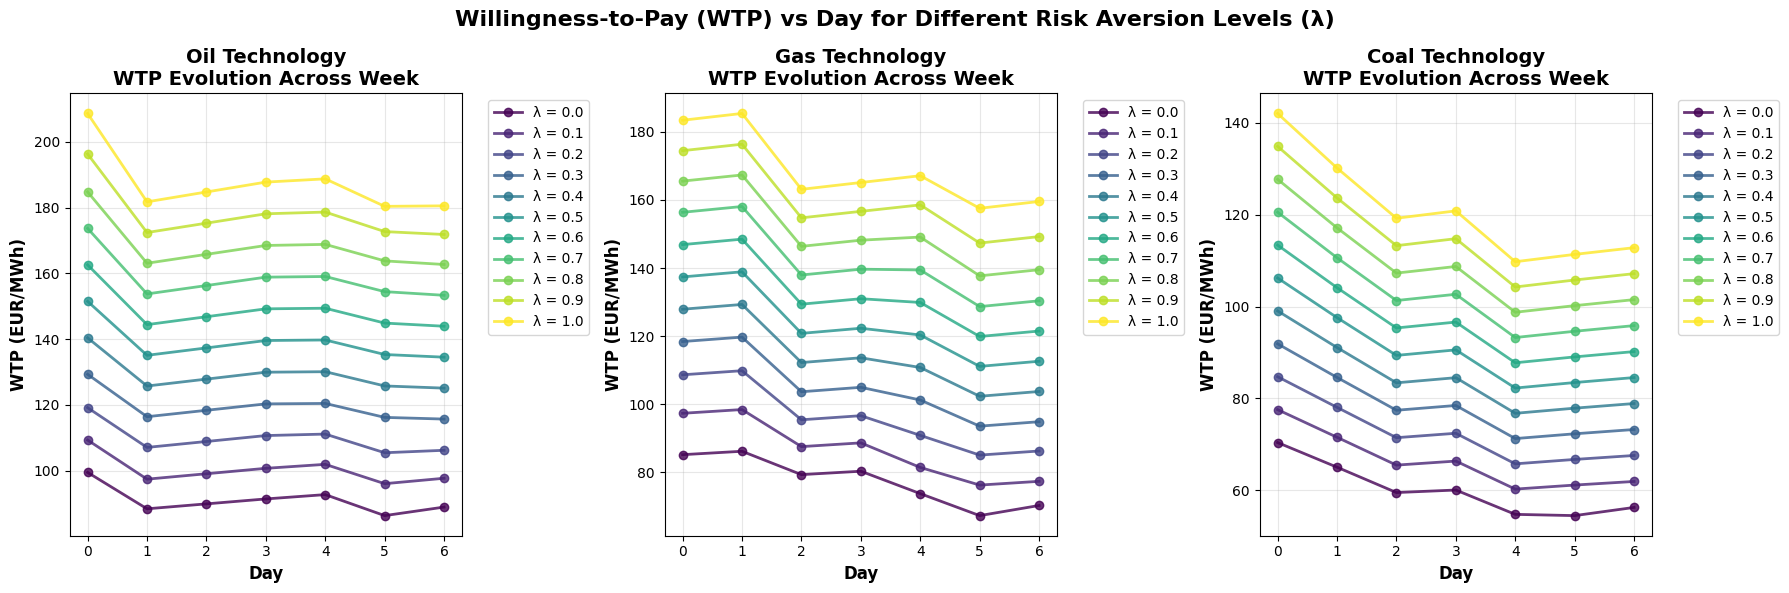

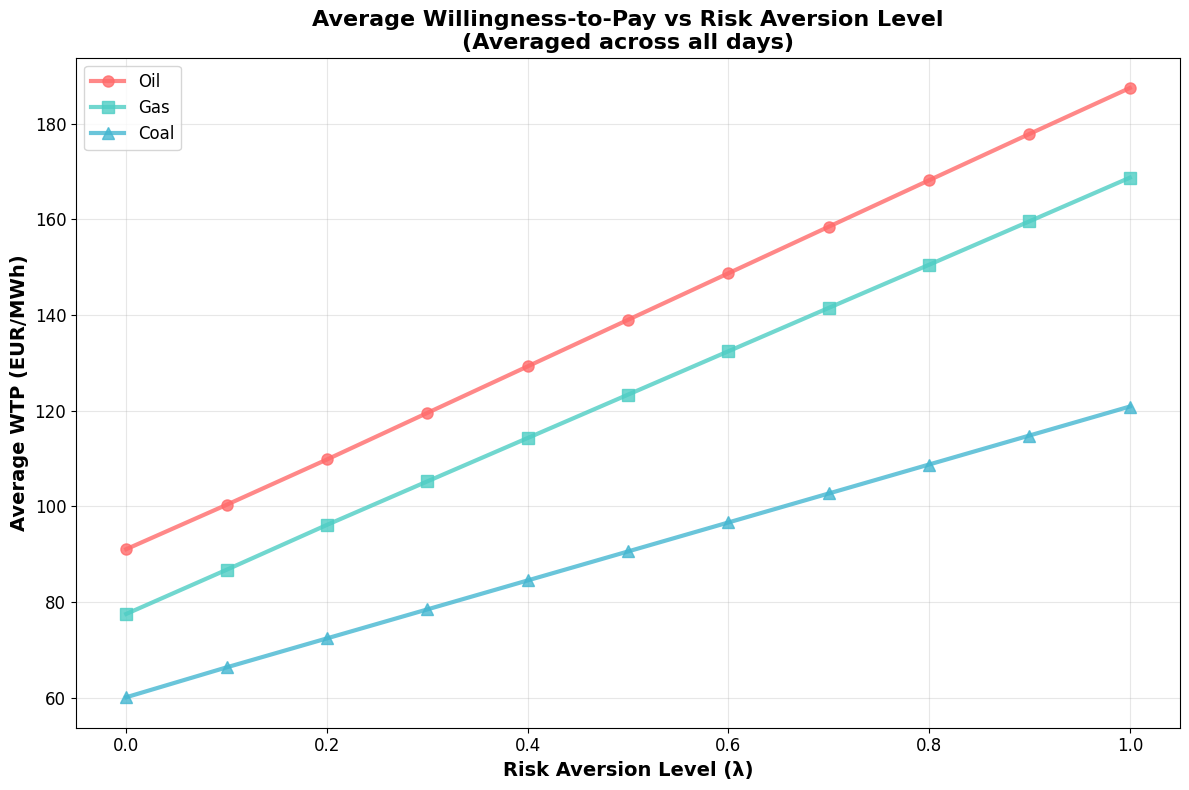

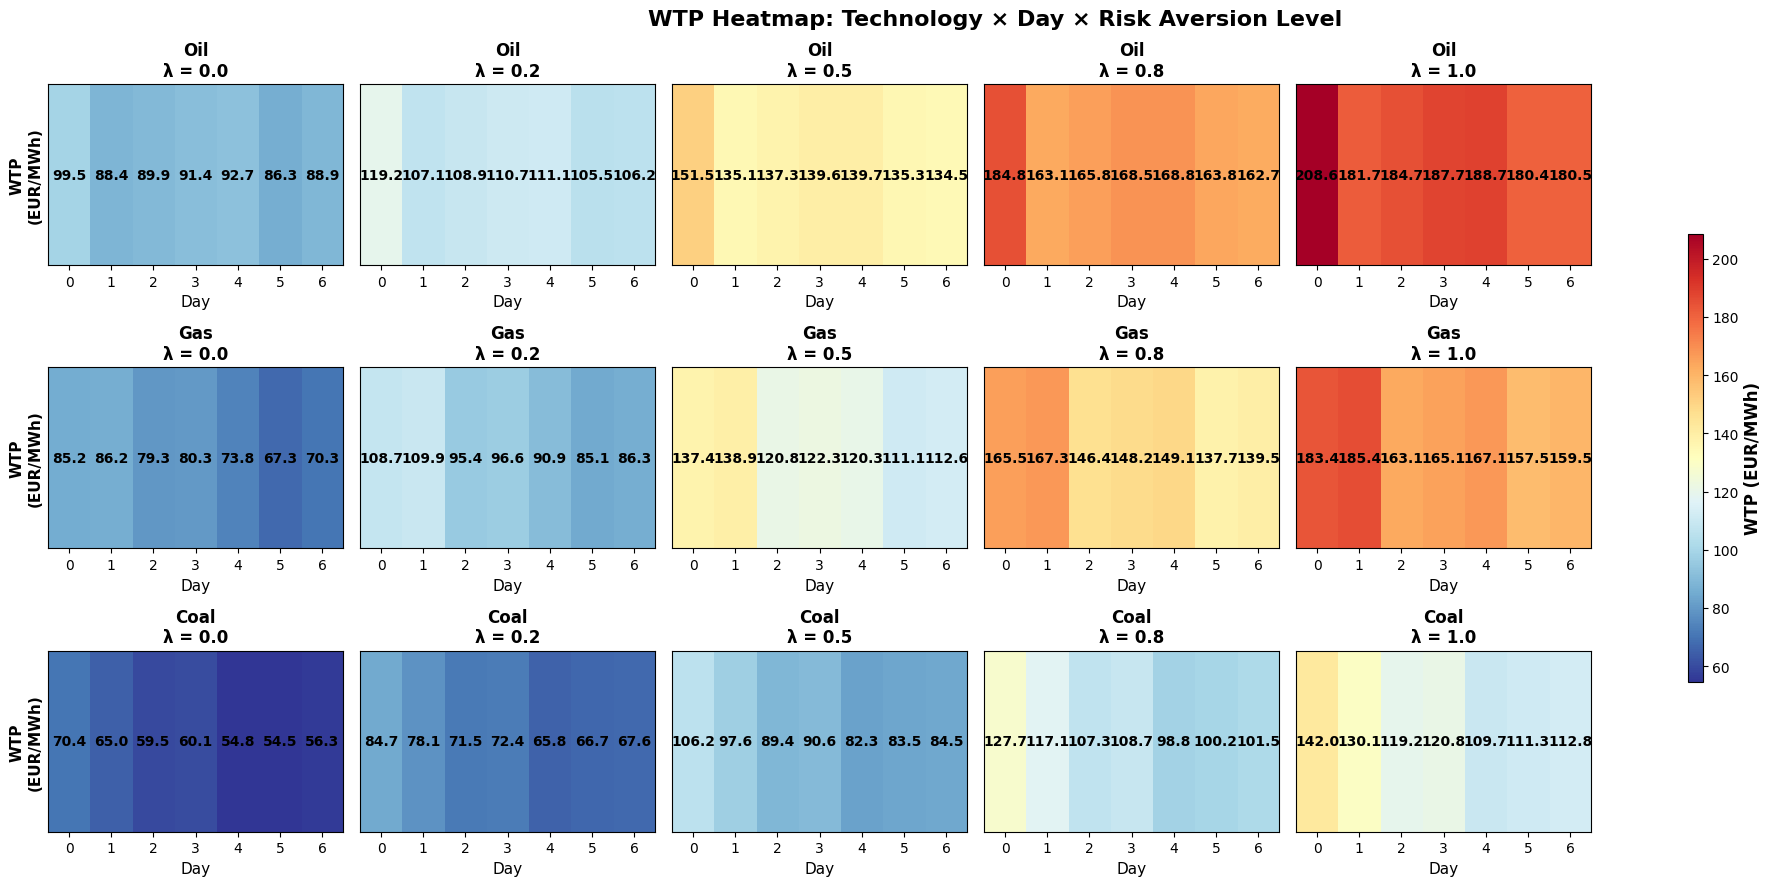

WTP ANALYSIS SUMMARY

Oil Technology:
Lambda   Min WTP    Max WTP    Avg WTP    Std WTP   
--------------------------------------------------
0.0      86.35      99.48      91.04      3.94      
0.1      96.05      109.32     100.32     4.12      
0.2      105.46     119.16     109.80     4.31      
0.3      115.70     129.31     119.54     4.37      
0.4      125.11     140.40     129.27     4.91      
0.5      134.51     151.49     139.01     5.46      
0.6      143.92     162.58     148.74     6.01      
0.7      153.33     173.67     158.48     6.56      
0.8      162.69     184.76     168.20     7.14      
0.9      171.81     196.30     177.89     7.93      
1.0      180.37     208.61     187.49     9.16      

Gas Technology:
Lambda   Min WTP    Max WTP    Avg WTP    Std WTP   
--------------------------------------------------
0.0      67.31      86.20      77.50      6.72      
0.1      76.28      98.45      86.74      8.27      
0.2      85.08      109.86     96.12      9.20  

In [16]:
# -------------------------------------------------------
# Create WTP Plots for Different Lambda Values and Technologies
# -------------------------------------------------------

def create_wtp_plots(wtp_data, lambda_vals):
    """
    Create three separate plots showing WTP vs Day for each technology,
    with different lines for different lambda values
    """
    
    # Set up the plotting style
    plt.style.use('default')
    colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_vals)))
    
    # Create figure with 3 subplots (one for each technology)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Willingness-to-Pay (WTP) vs Day for Different Risk Aversion Levels (λ)', 
                 fontsize=16, fontweight='bold')
    
    days = list(range(len(next(iter(next(iter(wtp_data.values())).values())))))
    
    # Plot for each technology
    for tech_idx, tech in enumerate(TECHS):
        ax = axes[tech_idx]
        
        # Plot lines for each lambda value
        for lambda_idx, lambda_val in enumerate(lambda_vals):
            if lambda_val in wtp_data[tech]:
                wtp_values = wtp_data[tech][lambda_val]
                ax.plot(days, wtp_values, 
                       color=colors[lambda_idx], 
                       marker='o', 
                       linewidth=2, 
                       markersize=6,
                       label=f'λ = {lambda_val:.1f}',
                       alpha=0.8)
        
        ax.set_xlabel('Day', fontsize=12, fontweight='bold')
        ax.set_ylabel('WTP (EUR/MWh)', fontsize=12, fontweight='bold')
        ax.set_title(f'{tech} Technology\nWTP Evolution Across Week', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # Add some styling
        ax.set_xticks(days)
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Additional Analysis Plot: Lambda vs Average WTP
    # -------------------------------------------------------
    
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))
    
    # Calculate average WTP across days for each tech and lambda
    avg_wtp_by_lambda = {tech: [] for tech in TECHS}
    
    for tech in TECHS:
        for lambda_val in lambda_vals:
            if lambda_val in wtp_data[tech]:
                avg_wtp = np.mean(wtp_data[tech][lambda_val])
                avg_wtp_by_lambda[tech].append(avg_wtp)
            else:
                avg_wtp_by_lambda[tech].append(np.nan)
    
    # Plot average WTP vs lambda for each technology
    tech_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    tech_markers = ['o', 's', '^']
    
    for tech_idx, tech in enumerate(TECHS):
        ax2.plot(lambda_vals, avg_wtp_by_lambda[tech], 
                color=tech_colors[tech_idx],
                marker=tech_markers[tech_idx],
                linewidth=3,
                markersize=8,
                label=f'{tech}',
                alpha=0.8)
    
    ax2.set_xlabel('Risk Aversion Level (λ)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average WTP (EUR/MWh)', fontsize=14, fontweight='bold')
    ax2.set_title('Average Willingness-to-Pay vs Risk Aversion Level\n(Averaged across all days)', 
                 fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12, loc='best')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Heatmap Plot: WTP by Technology, Day, and Lambda (selected lambdas)
    # -------------------------------------------------------
    
    # Select a few representative lambda values for heatmap
    selected_lambdas = [0.0, 0.2, 0.5, 0.8, 1.0]
    available_lambdas = [l for l in selected_lambdas if l in lambda_vals]
    
    fig3, axes3 = plt.subplots(len(TECHS), len(available_lambdas), 
                              figsize=(4*len(available_lambdas), 3*len(TECHS)))
    
    if len(TECHS) == 1:
        axes3 = axes3.reshape(1, -1)
    if len(available_lambdas) == 1:
        axes3 = axes3.reshape(-1, 1)
    
    fig3.suptitle('WTP Heatmap: Technology × Day × Risk Aversion Level', 
                 fontsize=16, fontweight='bold')
    
    # Find global min/max for consistent color scale
    all_wtp_values = []
    for tech in TECHS:
        for lambda_val in available_lambdas:
            if lambda_val in wtp_data[tech]:
                all_wtp_values.extend(wtp_data[tech][lambda_val])
    
    if all_wtp_values:
        vmin, vmax = min(all_wtp_values), max(all_wtp_values)
        
        for tech_idx, tech in enumerate(TECHS):
            for lambda_idx, lambda_val in enumerate(available_lambdas):
                ax = axes3[tech_idx, lambda_idx]
                
                if lambda_val in wtp_data[tech]:
                    wtp_values = np.array(wtp_data[tech][lambda_val]).reshape(1, -1)
                    
                    im = ax.imshow(wtp_values, cmap='RdYlBu_r', aspect='auto',
                                  vmin=vmin, vmax=vmax)
                    
                    # Add value annotations
                    for day_idx in range(len(days)):
                        ax.text(day_idx, 0, f'{wtp_values[0, day_idx]:.1f}',
                               ha='center', va='center', fontweight='bold', fontsize=10)
                
                ax.set_title(f'{tech}\nλ = {lambda_val:.1f}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Day', fontsize=11)
                ax.set_xticks(range(len(days)))
                ax.set_xticklabels(days)
                ax.set_yticks([])
                
                if lambda_idx == 0:
                    ax.set_ylabel('WTP\n(EUR/MWh)', fontsize=11, fontweight='bold')
        
        # Add colorbar
        plt.tight_layout()
        cbar = fig3.colorbar(im, ax=axes3.ravel().tolist(), shrink=0.6, aspect=30)
        cbar.set_label('WTP (EUR/MWh)', fontsize=12, fontweight='bold')
    
    plt.show()
    
    # -------------------------------------------------------
    # Summary Statistics Table
    # -------------------------------------------------------
    
    print("="*80)
    print("WTP ANALYSIS SUMMARY")
    print("="*80)
    
    for tech in TECHS:
        print(f"\n{tech} Technology:")
        print(f"{'Lambda':<8} {'Min WTP':<10} {'Max WTP':<10} {'Avg WTP':<10} {'Std WTP':<10}")
        print("-" * 50)
        
        for lambda_val in lambda_vals:
            if lambda_val in wtp_data[tech]:
                wtp_values = wtp_data[tech][lambda_val]
                min_wtp = min(wtp_values)
                max_wtp = max(wtp_values)
                avg_wtp = np.mean(wtp_values)
                std_wtp = np.std(wtp_values)
                
                print(f"{lambda_val:<8.1f} {min_wtp:<10.2f} {max_wtp:<10.2f} {avg_wtp:<10.2f} {std_wtp:<10.2f}")

# Create all the plots
create_wtp_plots(wtp_data, lambda_vals)